### Import Libraries

In [111]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.distributions as dist
from torchsummary import summary
import math
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path
import re
from skimage.metrics  import structural_similarity as ssim

from importlib import reload
import visualization

# locals
import model_architectures_2d

reload(model_architectures_2d)
from model_architectures_2d import DataSeg2Seg, UNet, MiniUNet, MinierUNet, DataSeg2SegUnbatched, VAE

reload(visualization)
from visualization import brain_diff, viz_slices

### Define Paths

In [2]:
research_dir = r"D:/school/research"
code_dir = os.path.join(research_dir, "code")
model_dir = os.path.join(code_dir, "explore_again", "models")
data_dir = os.path.join(research_dir, "data")
dhcp_rel2 = os.path.join(data_dir, "dhcp_rel2")
processed_dir = os.path.join(dhcp_rel2, "processed")
volume_dir = os.path.join(processed_dir, "volumes")
seg_dir = os.path.join(processed_dir, "segments")
seg_vol_dir = os.path.join(processed_dir, "volume_segments")
pred_dir = os.path.join(dhcp_rel2, "predictions")
seg_pred_dir = os.path.join(pred_dir, "vae_9seg")

l1_dir = os.path.join(volume_dir, "l1")
l5_dir = os.path.join(volume_dir, "l5")

l1_seg_dir = os.path.join(seg_dir, "l1")
l5_seg_dir = os.path.join(seg_dir, "l5")

l1_seg_vol_dir = os.path.join(seg_vol_dir, "l1")
l5_seg_vol_dir = os.path.join(seg_vol_dir, "l5")

l1_seg_pred_dir = os.path.join(seg_pred_dir, "l1")
l5_seg_pred_dir = os.path.join(seg_pred_dir, "l5")

slice_out = os.path.join(pred_dir, "vae_9seg_residuals")
train_out = os.path.join(slice_out, "train")
val_out = os.path.join(slice_out, "val")
test_out = os.path.join(slice_out, "test")

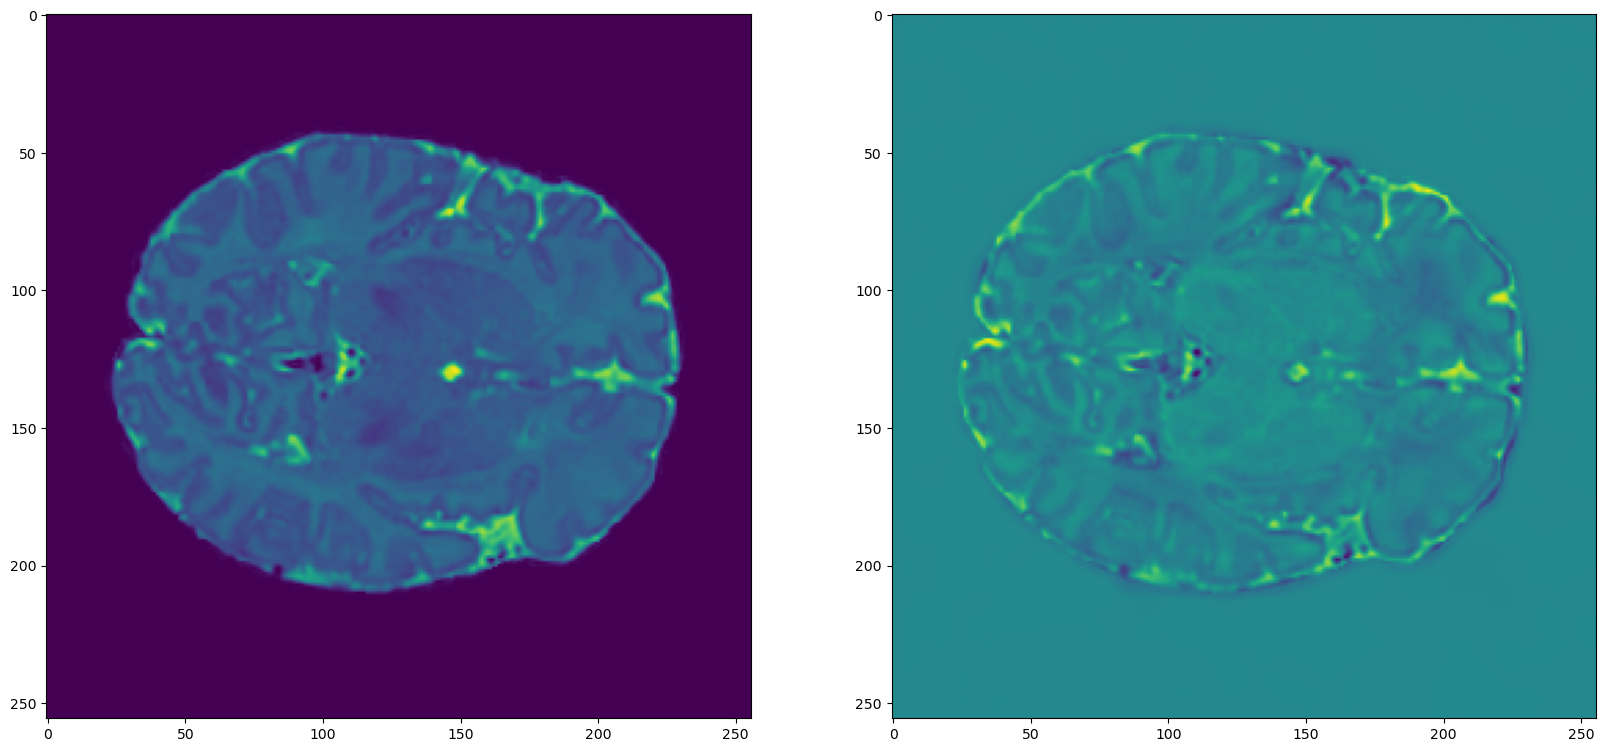

In [8]:
og_path = os.path.join(train_out, "sub-CC00062XX05_13801_slice128_og.npy")
res_path = os.path.join(train_out, "sub-CC00062XX05_13801_slice128_residual.npy")

og = np.load(og_path)
res = np.load(res_path)

fig, ax = plt.subplots(1,2, figsize=(20,20))
ax[0].imshow(np.sum(og, axis=0))
ax[1].imshow(np.sum(res, axis=0))

### Load Data

In [146]:
class DataRes2SegSlice(Dataset):
    def __init__(self, data_dir, seg_num, slice_num):
        self.data_dir = data_dir
        self.seg_num = seg_num
        self.slice_num = slice_num
        self.og_list = sorted([x for x in os.listdir(self.data_dir) if x.endswith("og.npy") and f"slice{slice_num}" in x])
        self.res_list = sorted([x for x in os.listdir(self.data_dir) if x.endswith("residual.npy") and f"slice{slice_num}" in x])
        # self.file_list = [y for x,y in enumerate(zip(self.seg_list, self.pred_list)) if x in indices]
        
        # save for sort if needed
        # sorted(train.og_list, key = lambda x: int(x.split("slice")[-1].split("_")[0]))
        
    def __len__(self):
        return len(self.og_list)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        og_path = os.path.join(self.data_dir, self.og_list[idx])
        og = np.load(og_path)[self.seg_num]
        og = np.reshape(og, (1, 256, 256))
        
        res_path = os.path.join(self.data_dir, self.res_list[idx])
        res = np.load(res_path)[self.seg_num]
        res = np.reshape(res, (1, 256, 256))
        
        return {"og": og, "res": res}


class DataRes2Seg(Dataset):
    def __init__(self, data_dir, seg_num):
        self.data_dir = data_dir
        self.seg_num = seg_num
        self.og_list = sorted([x for x in os.listdir(self.data_dir) if x.endswith("og.npy")])
        self.res_list = sorted([x for x in os.listdir(self.data_dir) if x.endswith("residual.npy")])
        # self.file_list = [y for x,y in enumerate(zip(self.seg_list, self.pred_list)) if x in indices]
        
        # save for sort if needed
        # sorted(train.og_list, key = lambda x: int(x.split("slice")[-1].split("_")[0]))
        
    def __len__(self):
        return len(self.og_list)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        og_path = os.path.join(self.data_dir, self.og_list[idx])
        og = np.load(og_path)[self.seg_num]
        og = np.reshape(og, (1, 256, 256))
        
        res_path = os.path.join(self.data_dir, self.res_list[idx])
        res = np.load(res_path)[self.seg_num]
        res = np.reshape(res, (1, 256, 256))
        
        return {"og": og, "res": res}


In [53]:
train = DataRes2SegSlice(train_out, 2, 128)
val = DataRes2SegSlice(val_out, 2, 128)
test = DataRes2SegSlice(test_out, 2, 128)

batch_size=32
train_loader = DataLoader(train, batch_size=batch_size)
val_loader = DataLoader(val, batch_size=batch_size)

# Model Tests Middle Slice

### MiniUNet on Cortical Grey Matter Residuals

In [143]:
### This initializes a minier unet with the ground truth in and out
model = MiniUNet(1)

model.cuda()
criterion = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=1e-07)

num_epochs = 100
for epoch in range(num_epochs):
    total_loss = 0
    with tqdm(train_loader, unit="batch", ascii=' >=') as tepoch:
        model.train()
        data_counter = 0
        for data in tepoch:
            optimizer.zero_grad()
            
            og = data["og"].cuda()
            residual = data["res"].cuda()

            output = model(residual)
            loss = criterion(og, output)

            # backward
            loss.backward()
            optimizer.step()

            total_loss += loss.data
            data_counter += 1

        total_loss /= (data_counter)
        
        tepoch.set_postfix(loss=loss.item())
        val_loss = 0
        model.eval()
        data_counter = 0
        for data in val_loader:
            with torch.no_grad():
                og = data["og"].cuda()
                residual = data["res"].cuda()

                output = model(residual)
                loss = criterion(og, output)

                val_loss += loss.data
                data_counter += 1
        
        val_loss /= data_counter
        
        
        print('epoch [{}/{}], train_loss:{:.4f}, val_loss:{:.4f}'
              .format(epoch+1, num_epochs, total_loss, val_loss))

100%|=================================================================================| 6/6 [00:01<00:00,  4.93batch/s]


epoch [1/100], train_loss:0.2383, val_loss:0.0428


100%|=================================================================================| 6/6 [00:01<00:00,  5.01batch/s]


epoch [2/100], train_loss:0.0534, val_loss:0.0415


100%|=================================================================================| 6/6 [00:01<00:00,  4.72batch/s]


epoch [3/100], train_loss:0.0164, val_loss:0.0212


100%|=================================================================================| 6/6 [00:01<00:00,  4.94batch/s]


epoch [4/100], train_loss:0.0085, val_loss:0.0159


100%|=================================================================================| 6/6 [00:01<00:00,  4.96batch/s]


epoch [5/100], train_loss:0.0064, val_loss:0.0154


100%|=================================================================================| 6/6 [00:01<00:00,  5.01batch/s]


epoch [6/100], train_loss:0.0048, val_loss:0.0168


100%|=================================================================================| 6/6 [00:01<00:00,  4.87batch/s]


epoch [7/100], train_loss:0.0041, val_loss:0.0173


100%|=================================================================================| 6/6 [00:01<00:00,  4.85batch/s]


epoch [8/100], train_loss:0.0035, val_loss:0.0174


100%|=================================================================================| 6/6 [00:01<00:00,  4.85batch/s]


epoch [9/100], train_loss:0.0030, val_loss:0.0171


100%|=================================================================================| 6/6 [00:01<00:00,  5.01batch/s]


epoch [10/100], train_loss:0.0027, val_loss:0.0169


100%|=================================================================================| 6/6 [00:01<00:00,  5.00batch/s]


epoch [11/100], train_loss:0.0024, val_loss:0.0165


100%|=================================================================================| 6/6 [00:01<00:00,  4.97batch/s]


epoch [12/100], train_loss:0.0021, val_loss:0.0163


100%|=================================================================================| 6/6 [00:01<00:00,  5.02batch/s]


epoch [13/100], train_loss:0.0019, val_loss:0.0157


100%|=================================================================================| 6/6 [00:01<00:00,  5.01batch/s]


epoch [14/100], train_loss:0.0017, val_loss:0.0154


100%|=================================================================================| 6/6 [00:01<00:00,  4.99batch/s]


epoch [15/100], train_loss:0.0016, val_loss:0.0150


100%|=================================================================================| 6/6 [00:01<00:00,  5.00batch/s]


epoch [16/100], train_loss:0.0015, val_loss:0.0148


100%|=================================================================================| 6/6 [00:01<00:00,  5.01batch/s]


epoch [17/100], train_loss:0.0014, val_loss:0.0147


100%|=================================================================================| 6/6 [00:01<00:00,  5.02batch/s]


epoch [18/100], train_loss:0.0013, val_loss:0.0146


100%|=================================================================================| 6/6 [00:01<00:00,  5.02batch/s]


epoch [19/100], train_loss:0.0012, val_loss:0.0145


100%|=================================================================================| 6/6 [00:01<00:00,  5.02batch/s]


epoch [20/100], train_loss:0.0012, val_loss:0.0144


100%|=================================================================================| 6/6 [00:01<00:00,  5.02batch/s]


epoch [21/100], train_loss:0.0011, val_loss:0.0144


100%|=================================================================================| 6/6 [00:01<00:00,  4.96batch/s]


epoch [22/100], train_loss:0.0011, val_loss:0.0144


100%|=================================================================================| 6/6 [00:01<00:00,  5.03batch/s]


epoch [23/100], train_loss:0.0010, val_loss:0.0145


100%|=================================================================================| 6/6 [00:01<00:00,  5.03batch/s]


epoch [24/100], train_loss:0.0010, val_loss:0.0145


100%|=================================================================================| 6/6 [00:01<00:00,  5.03batch/s]


epoch [25/100], train_loss:0.0009, val_loss:0.0146


100%|=================================================================================| 6/6 [00:01<00:00,  4.94batch/s]


epoch [26/100], train_loss:0.0009, val_loss:0.0146


100%|=================================================================================| 6/6 [00:01<00:00,  4.97batch/s]


epoch [27/100], train_loss:0.0009, val_loss:0.0146


100%|=================================================================================| 6/6 [00:01<00:00,  4.98batch/s]


epoch [28/100], train_loss:0.0008, val_loss:0.0147


100%|=================================================================================| 6/6 [00:01<00:00,  5.00batch/s]


epoch [29/100], train_loss:0.0008, val_loss:0.0147


100%|=================================================================================| 6/6 [00:01<00:00,  5.04batch/s]


epoch [30/100], train_loss:0.0008, val_loss:0.0148


100%|=================================================================================| 6/6 [00:01<00:00,  5.01batch/s]


epoch [31/100], train_loss:0.0008, val_loss:0.0148


100%|=================================================================================| 6/6 [00:01<00:00,  4.96batch/s]


epoch [32/100], train_loss:0.0007, val_loss:0.0149


100%|=================================================================================| 6/6 [00:01<00:00,  4.65batch/s]


epoch [33/100], train_loss:0.0007, val_loss:0.0150


100%|=================================================================================| 6/6 [00:01<00:00,  4.96batch/s]


epoch [34/100], train_loss:0.0007, val_loss:0.0151


100%|=================================================================================| 6/6 [00:01<00:00,  5.04batch/s]


epoch [35/100], train_loss:0.0007, val_loss:0.0152


100%|=================================================================================| 6/6 [00:01<00:00,  4.75batch/s]


epoch [36/100], train_loss:0.0007, val_loss:0.0153


100%|=================================================================================| 6/6 [00:01<00:00,  4.84batch/s]


epoch [37/100], train_loss:0.0007, val_loss:0.0153


100%|=================================================================================| 6/6 [00:01<00:00,  4.90batch/s]


epoch [38/100], train_loss:0.0006, val_loss:0.0154


100%|=================================================================================| 6/6 [00:01<00:00,  4.94batch/s]


epoch [39/100], train_loss:0.0006, val_loss:0.0154


100%|=================================================================================| 6/6 [00:01<00:00,  5.01batch/s]


epoch [40/100], train_loss:0.0006, val_loss:0.0153


100%|=================================================================================| 6/6 [00:01<00:00,  5.01batch/s]


epoch [41/100], train_loss:0.0006, val_loss:0.0154


100%|=================================================================================| 6/6 [00:01<00:00,  5.00batch/s]


epoch [42/100], train_loss:0.0006, val_loss:0.0155


100%|=================================================================================| 6/6 [00:01<00:00,  4.91batch/s]


epoch [43/100], train_loss:0.0006, val_loss:0.0154


100%|=================================================================================| 6/6 [00:01<00:00,  4.95batch/s]


epoch [44/100], train_loss:0.0006, val_loss:0.0154


100%|=================================================================================| 6/6 [00:01<00:00,  4.96batch/s]


epoch [45/100], train_loss:0.0005, val_loss:0.0155


100%|=================================================================================| 6/6 [00:01<00:00,  5.03batch/s]


epoch [46/100], train_loss:0.0005, val_loss:0.0155


100%|=================================================================================| 6/6 [00:01<00:00,  4.96batch/s]


epoch [47/100], train_loss:0.0005, val_loss:0.0156


100%|=================================================================================| 6/6 [00:01<00:00,  4.93batch/s]


epoch [48/100], train_loss:0.0005, val_loss:0.0157


100%|=================================================================================| 6/6 [00:01<00:00,  5.03batch/s]


epoch [49/100], train_loss:0.0005, val_loss:0.0157


100%|=================================================================================| 6/6 [00:01<00:00,  4.98batch/s]


epoch [50/100], train_loss:0.0005, val_loss:0.0157


100%|=================================================================================| 6/6 [00:01<00:00,  4.97batch/s]


epoch [51/100], train_loss:0.0005, val_loss:0.0157


100%|=================================================================================| 6/6 [00:01<00:00,  5.01batch/s]


epoch [52/100], train_loss:0.0005, val_loss:0.0158


100%|=================================================================================| 6/6 [00:01<00:00,  5.00batch/s]


epoch [53/100], train_loss:0.0005, val_loss:0.0158


100%|=================================================================================| 6/6 [00:01<00:00,  4.97batch/s]


epoch [54/100], train_loss:0.0004, val_loss:0.0158


100%|=================================================================================| 6/6 [00:01<00:00,  4.82batch/s]


epoch [55/100], train_loss:0.0004, val_loss:0.0158


100%|=================================================================================| 6/6 [00:01<00:00,  4.93batch/s]


epoch [56/100], train_loss:0.0004, val_loss:0.0159


100%|=================================================================================| 6/6 [00:01<00:00,  4.95batch/s]


epoch [57/100], train_loss:0.0004, val_loss:0.0159


100%|=================================================================================| 6/6 [00:01<00:00,  4.94batch/s]


epoch [58/100], train_loss:0.0004, val_loss:0.0159


100%|=================================================================================| 6/6 [00:01<00:00,  4.95batch/s]


epoch [59/100], train_loss:0.0004, val_loss:0.0159


100%|=================================================================================| 6/6 [00:01<00:00,  5.00batch/s]


epoch [60/100], train_loss:0.0004, val_loss:0.0159


100%|=================================================================================| 6/6 [00:01<00:00,  4.96batch/s]


epoch [61/100], train_loss:0.0004, val_loss:0.0159


100%|=================================================================================| 6/6 [00:01<00:00,  4.99batch/s]


epoch [62/100], train_loss:0.0004, val_loss:0.0159


100%|=================================================================================| 6/6 [00:01<00:00,  4.99batch/s]


epoch [63/100], train_loss:0.0004, val_loss:0.0159


100%|=================================================================================| 6/6 [00:01<00:00,  4.71batch/s]


epoch [64/100], train_loss:0.0004, val_loss:0.0160


100%|=================================================================================| 6/6 [00:01<00:00,  4.93batch/s]


epoch [65/100], train_loss:0.0004, val_loss:0.0160


100%|=================================================================================| 6/6 [00:01<00:00,  4.94batch/s]


epoch [66/100], train_loss:0.0004, val_loss:0.0160


100%|=================================================================================| 6/6 [00:01<00:00,  5.01batch/s]


epoch [67/100], train_loss:0.0004, val_loss:0.0160


100%|=================================================================================| 6/6 [00:01<00:00,  4.93batch/s]


epoch [68/100], train_loss:0.0004, val_loss:0.0160


100%|=================================================================================| 6/6 [00:01<00:00,  5.00batch/s]


epoch [69/100], train_loss:0.0004, val_loss:0.0160


100%|=================================================================================| 6/6 [00:01<00:00,  4.88batch/s]


epoch [70/100], train_loss:0.0004, val_loss:0.0160


100%|=================================================================================| 6/6 [00:01<00:00,  5.00batch/s]


epoch [71/100], train_loss:0.0004, val_loss:0.0160


100%|=================================================================================| 6/6 [00:01<00:00,  4.94batch/s]


epoch [72/100], train_loss:0.0003, val_loss:0.0160


100%|=================================================================================| 6/6 [00:01<00:00,  4.89batch/s]


epoch [73/100], train_loss:0.0003, val_loss:0.0160


100%|=================================================================================| 6/6 [00:01<00:00,  4.87batch/s]


epoch [74/100], train_loss:0.0003, val_loss:0.0160


100%|=================================================================================| 6/6 [00:01<00:00,  5.01batch/s]


epoch [75/100], train_loss:0.0003, val_loss:0.0160


100%|=================================================================================| 6/6 [00:01<00:00,  5.03batch/s]


epoch [76/100], train_loss:0.0003, val_loss:0.0161


100%|=================================================================================| 6/6 [00:01<00:00,  4.96batch/s]


epoch [77/100], train_loss:0.0003, val_loss:0.0161


100%|=================================================================================| 6/6 [00:01<00:00,  4.90batch/s]


epoch [78/100], train_loss:0.0003, val_loss:0.0160


100%|=================================================================================| 6/6 [00:01<00:00,  4.75batch/s]


epoch [79/100], train_loss:0.0003, val_loss:0.0160


100%|=================================================================================| 6/6 [00:01<00:00,  4.87batch/s]


epoch [80/100], train_loss:0.0003, val_loss:0.0161


100%|=================================================================================| 6/6 [00:01<00:00,  4.98batch/s]


epoch [81/100], train_loss:0.0003, val_loss:0.0161


100%|=================================================================================| 6/6 [00:01<00:00,  4.97batch/s]


epoch [82/100], train_loss:0.0003, val_loss:0.0161


100%|=================================================================================| 6/6 [00:01<00:00,  5.02batch/s]


epoch [83/100], train_loss:0.0003, val_loss:0.0160


100%|=================================================================================| 6/6 [00:01<00:00,  4.95batch/s]


epoch [84/100], train_loss:0.0003, val_loss:0.0161


100%|=================================================================================| 6/6 [00:01<00:00,  5.01batch/s]


epoch [85/100], train_loss:0.0003, val_loss:0.0161


100%|=================================================================================| 6/6 [00:01<00:00,  4.99batch/s]


epoch [86/100], train_loss:0.0003, val_loss:0.0161


100%|=================================================================================| 6/6 [00:01<00:00,  4.96batch/s]


epoch [87/100], train_loss:0.0003, val_loss:0.0162


100%|=================================================================================| 6/6 [00:01<00:00,  5.03batch/s]


epoch [88/100], train_loss:0.0003, val_loss:0.0162


100%|=================================================================================| 6/6 [00:01<00:00,  4.98batch/s]


epoch [89/100], train_loss:0.0003, val_loss:0.0162


100%|=================================================================================| 6/6 [00:01<00:00,  5.02batch/s]


epoch [90/100], train_loss:0.0003, val_loss:0.0162


100%|=================================================================================| 6/6 [00:01<00:00,  4.96batch/s]


epoch [91/100], train_loss:0.0003, val_loss:0.0163


100%|=================================================================================| 6/6 [00:01<00:00,  4.95batch/s]


epoch [92/100], train_loss:0.0003, val_loss:0.0163


100%|=================================================================================| 6/6 [00:01<00:00,  4.90batch/s]


epoch [93/100], train_loss:0.0003, val_loss:0.0163


100%|=================================================================================| 6/6 [00:01<00:00,  4.94batch/s]


epoch [94/100], train_loss:0.0003, val_loss:0.0163


100%|=================================================================================| 6/6 [00:01<00:00,  5.00batch/s]


epoch [95/100], train_loss:0.0003, val_loss:0.0163


100%|=================================================================================| 6/6 [00:01<00:00,  5.00batch/s]


epoch [96/100], train_loss:0.0003, val_loss:0.0164


100%|=================================================================================| 6/6 [00:01<00:00,  5.02batch/s]


epoch [97/100], train_loss:0.0003, val_loss:0.0164


100%|=================================================================================| 6/6 [00:01<00:00,  4.94batch/s]


epoch [98/100], train_loss:0.0003, val_loss:0.0164


100%|=================================================================================| 6/6 [00:01<00:00,  4.98batch/s]


epoch [99/100], train_loss:0.0003, val_loss:0.0164


100%|=================================================================================| 6/6 [00:01<00:00,  5.04batch/s]

epoch [100/100], train_loss:0.0003, val_loss:0.0164


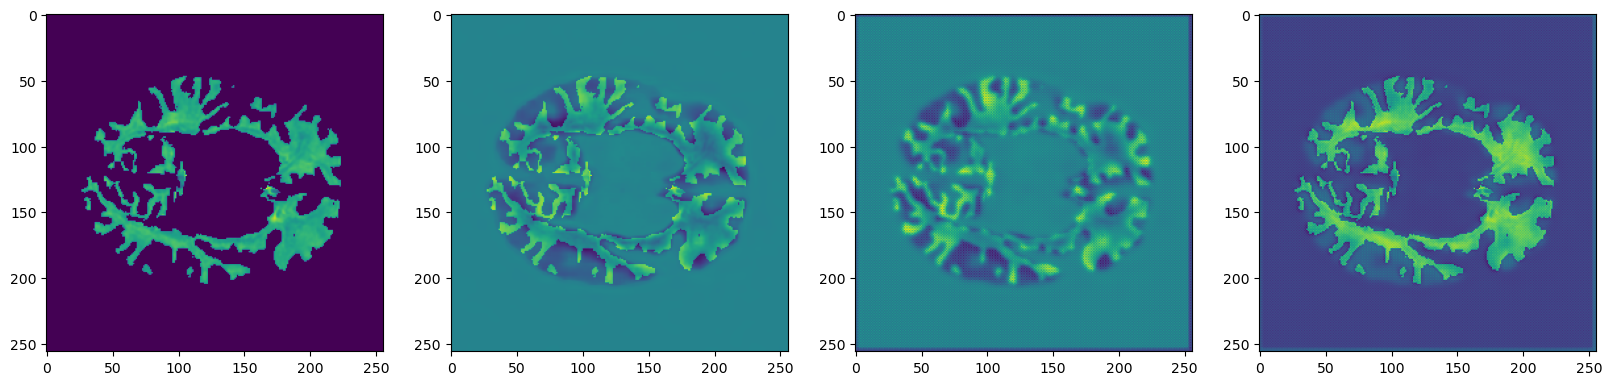

In [144]:
idx = 0
og = train[idx]["og"].reshape((256, 256))
res = train[idx]["res"].reshape((256, 256))

output = model(torch.Tensor(res).reshape((1, 1, 256, 256)).cuda())
output = output.detach().cpu().reshape((256, 256)).numpy()

fig, ax = plt.subplots(1, 4, figsize=(20,20))

ax[0].imshow(og)
ax[1].imshow(res)
ax[2].imshow(output)
ax[3].imshow(og - output)

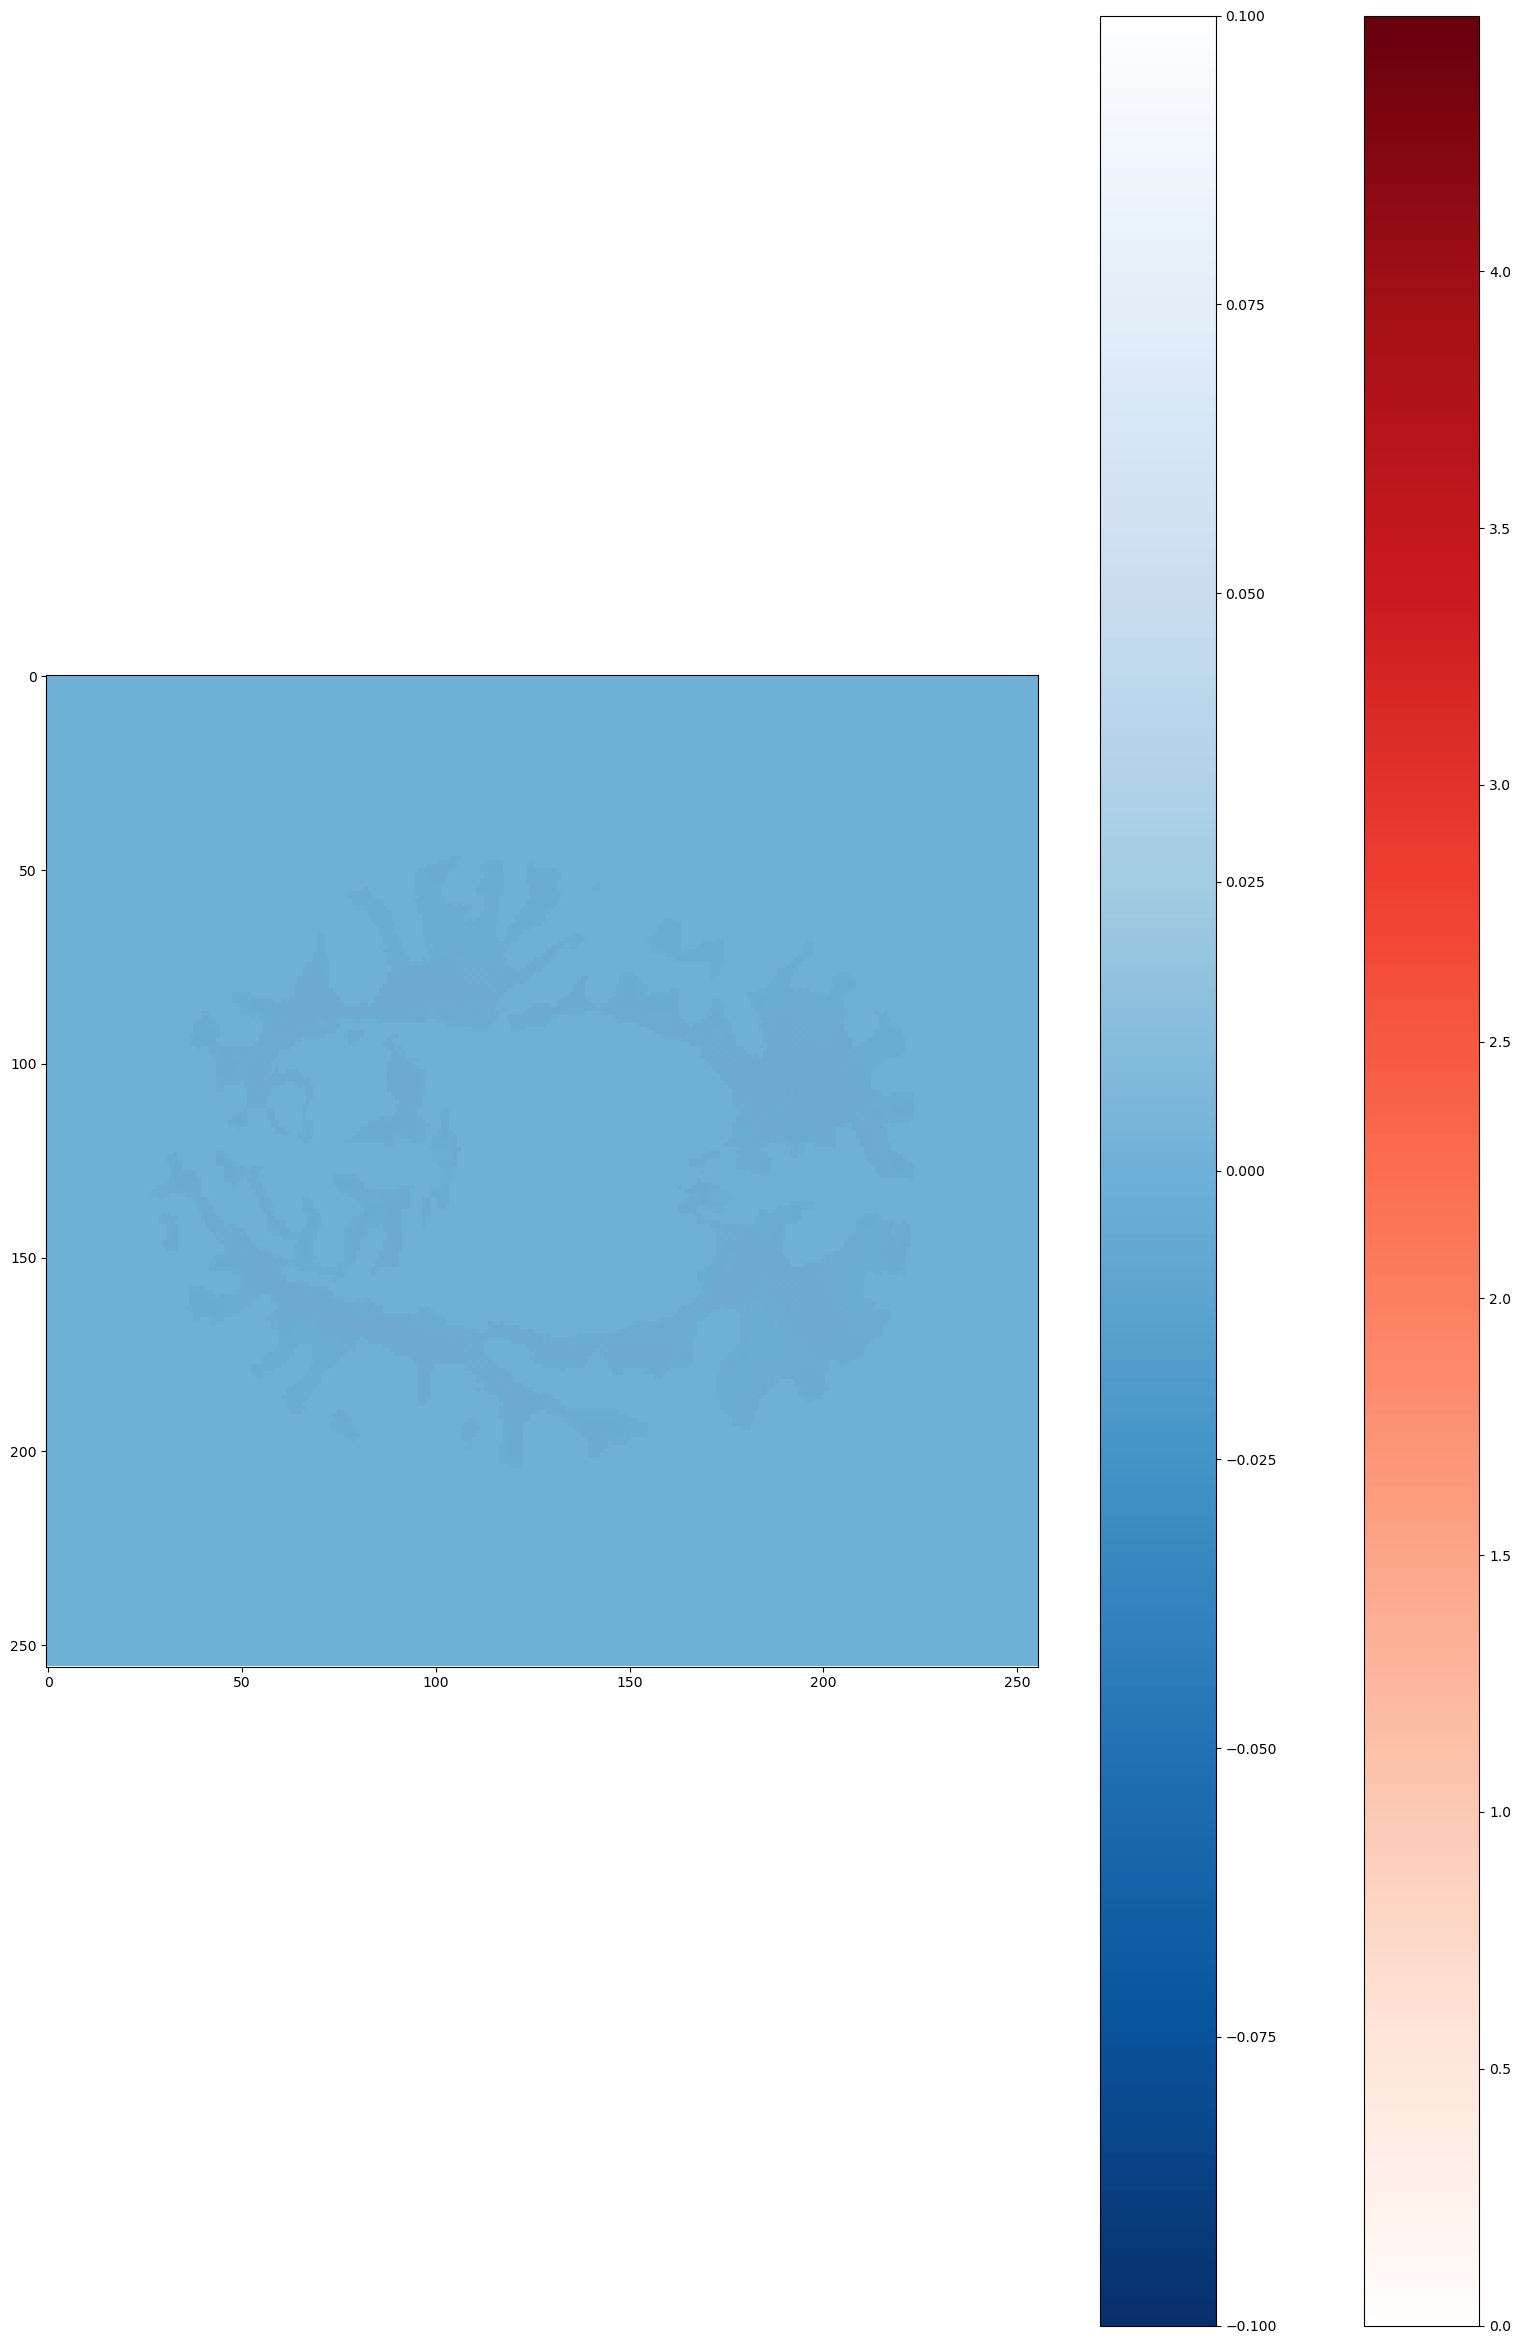

In [145]:
brain_diff(og, output)

### MinierUNet on Cortical Grey Matter Residuals

In [56]:
### This initializes a minier unet with the ground truth in and out
model = MinierUNet(1)

model.cuda()
criterion = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=1e-07)

num_epochs = 100
for epoch in range(num_epochs):
    total_loss = 0
    with tqdm(train_loader, unit="batch", ascii=' >=') as tepoch:
        model.train()
        data_counter = 0
        for data in tepoch:
            optimizer.zero_grad()
            
            og = data["og"].cuda()
            residual = data["res"].cuda()

            output = model(residual)
            loss = criterion(og, output)

            # backward
            loss.backward()
            optimizer.step()

            total_loss += loss.data
            data_counter += 1

        total_loss /= (data_counter)
        
        tepoch.set_postfix(loss=loss.item())
        val_loss = 0
        model.eval()
        data_counter = 0
        for data in val_loader:
            with torch.no_grad():
                og = data["og"].cuda()
                residual = data["res"].cuda()

                output = model(residual)
                loss = criterion(og, output)

                val_loss += loss.data
                data_counter += 1
        
        val_loss /= data_counter
        
        
        print('epoch [{}/{}], train_loss:{:.4f}, val_loss:{:.4f}'
              .format(epoch+1, num_epochs, total_loss, val_loss))

100%|=================================================================================| 6/6 [00:00<00:00,  6.58batch/s]


epoch [1/100], train_loss:0.1125, val_loss:0.0175


100%|=================================================================================| 6/6 [00:00<00:00,  6.69batch/s]


epoch [2/100], train_loss:0.0197, val_loss:0.0166


100%|=================================================================================| 6/6 [00:00<00:00,  6.73batch/s]


epoch [3/100], train_loss:0.0071, val_loss:0.0177


100%|=================================================================================| 6/6 [00:00<00:00,  6.68batch/s]


epoch [4/100], train_loss:0.0044, val_loss:0.0175


100%|=================================================================================| 6/6 [00:00<00:00,  6.69batch/s]


epoch [5/100], train_loss:0.0035, val_loss:0.0172


100%|=================================================================================| 6/6 [00:00<00:00,  6.67batch/s]


epoch [6/100], train_loss:0.0028, val_loss:0.0168


100%|=================================================================================| 6/6 [00:00<00:00,  6.67batch/s]


epoch [7/100], train_loss:0.0025, val_loss:0.0167


100%|=================================================================================| 6/6 [00:00<00:00,  6.66batch/s]


epoch [8/100], train_loss:0.0023, val_loss:0.0167


100%|=================================================================================| 6/6 [00:00<00:00,  6.69batch/s]


epoch [9/100], train_loss:0.0021, val_loss:0.0166


100%|=================================================================================| 6/6 [00:00<00:00,  6.70batch/s]


epoch [10/100], train_loss:0.0020, val_loss:0.0166


100%|=================================================================================| 6/6 [00:00<00:00,  6.69batch/s]


epoch [11/100], train_loss:0.0019, val_loss:0.0166


100%|=================================================================================| 6/6 [00:00<00:00,  6.71batch/s]


epoch [12/100], train_loss:0.0018, val_loss:0.0167


100%|=================================================================================| 6/6 [00:00<00:00,  6.70batch/s]


epoch [13/100], train_loss:0.0018, val_loss:0.0167


100%|=================================================================================| 6/6 [00:00<00:00,  6.70batch/s]


epoch [14/100], train_loss:0.0017, val_loss:0.0167


100%|=================================================================================| 6/6 [00:00<00:00,  6.71batch/s]


epoch [15/100], train_loss:0.0016, val_loss:0.0168


100%|=================================================================================| 6/6 [00:00<00:00,  6.69batch/s]


epoch [16/100], train_loss:0.0016, val_loss:0.0168


100%|=================================================================================| 6/6 [00:00<00:00,  6.71batch/s]


epoch [17/100], train_loss:0.0015, val_loss:0.0169


100%|=================================================================================| 6/6 [00:00<00:00,  6.71batch/s]


epoch [18/100], train_loss:0.0014, val_loss:0.0169


100%|=================================================================================| 6/6 [00:00<00:00,  6.73batch/s]


epoch [19/100], train_loss:0.0014, val_loss:0.0170


100%|=================================================================================| 6/6 [00:00<00:00,  6.69batch/s]


epoch [20/100], train_loss:0.0013, val_loss:0.0170


100%|=================================================================================| 6/6 [00:00<00:00,  6.73batch/s]


epoch [21/100], train_loss:0.0013, val_loss:0.0170


100%|=================================================================================| 6/6 [00:00<00:00,  6.69batch/s]


epoch [22/100], train_loss:0.0012, val_loss:0.0171


100%|=================================================================================| 6/6 [00:00<00:00,  6.72batch/s]


epoch [23/100], train_loss:0.0011, val_loss:0.0171


100%|=================================================================================| 6/6 [00:00<00:00,  6.72batch/s]


epoch [24/100], train_loss:0.0011, val_loss:0.0172


100%|=================================================================================| 6/6 [00:00<00:00,  6.65batch/s]


epoch [25/100], train_loss:0.0010, val_loss:0.0173


100%|=================================================================================| 6/6 [00:00<00:00,  6.70batch/s]


epoch [26/100], train_loss:0.0010, val_loss:0.0173


100%|=================================================================================| 6/6 [00:00<00:00,  6.72batch/s]


epoch [27/100], train_loss:0.0009, val_loss:0.0174


100%|=================================================================================| 6/6 [00:00<00:00,  6.74batch/s]


epoch [28/100], train_loss:0.0009, val_loss:0.0175


100%|=================================================================================| 6/6 [00:00<00:00,  6.71batch/s]


epoch [29/100], train_loss:0.0009, val_loss:0.0174


100%|=================================================================================| 6/6 [00:00<00:00,  6.70batch/s]


epoch [30/100], train_loss:0.0009, val_loss:0.0174


100%|=================================================================================| 6/6 [00:00<00:00,  6.73batch/s]


epoch [31/100], train_loss:0.0008, val_loss:0.0177


100%|=================================================================================| 6/6 [00:00<00:00,  6.72batch/s]


epoch [32/100], train_loss:0.0008, val_loss:0.0177


100%|=================================================================================| 6/6 [00:00<00:00,  6.72batch/s]


epoch [33/100], train_loss:0.0008, val_loss:0.0175


100%|=================================================================================| 6/6 [00:00<00:00,  6.72batch/s]


epoch [34/100], train_loss:0.0008, val_loss:0.0176


100%|=================================================================================| 6/6 [00:00<00:00,  6.72batch/s]


epoch [35/100], train_loss:0.0008, val_loss:0.0178


100%|=================================================================================| 6/6 [00:00<00:00,  6.71batch/s]


epoch [36/100], train_loss:0.0007, val_loss:0.0178


100%|=================================================================================| 6/6 [00:00<00:00,  6.41batch/s]


epoch [37/100], train_loss:0.0007, val_loss:0.0177


100%|=================================================================================| 6/6 [00:00<00:00,  6.68batch/s]


epoch [38/100], train_loss:0.0007, val_loss:0.0178


100%|=================================================================================| 6/6 [00:00<00:00,  6.51batch/s]


epoch [39/100], train_loss:0.0007, val_loss:0.0179


100%|=================================================================================| 6/6 [00:00<00:00,  6.69batch/s]


epoch [40/100], train_loss:0.0007, val_loss:0.0178


100%|=================================================================================| 6/6 [00:00<00:00,  6.47batch/s]


epoch [41/100], train_loss:0.0006, val_loss:0.0180


100%|=================================================================================| 6/6 [00:00<00:00,  6.18batch/s]


epoch [42/100], train_loss:0.0006, val_loss:0.0179


100%|=================================================================================| 6/6 [00:00<00:00,  6.48batch/s]


epoch [43/100], train_loss:0.0006, val_loss:0.0180


100%|=================================================================================| 6/6 [00:00<00:00,  6.66batch/s]


epoch [44/100], train_loss:0.0006, val_loss:0.0180


100%|=================================================================================| 6/6 [00:00<00:00,  6.66batch/s]


epoch [45/100], train_loss:0.0006, val_loss:0.0181


100%|=================================================================================| 6/6 [00:00<00:00,  6.48batch/s]


epoch [46/100], train_loss:0.0006, val_loss:0.0181


100%|=================================================================================| 6/6 [00:00<00:00,  6.59batch/s]


epoch [47/100], train_loss:0.0006, val_loss:0.0181


100%|=================================================================================| 6/6 [00:00<00:00,  6.49batch/s]


epoch [48/100], train_loss:0.0006, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.58batch/s]


epoch [49/100], train_loss:0.0006, val_loss:0.0181


100%|=================================================================================| 6/6 [00:00<00:00,  6.64batch/s]


epoch [50/100], train_loss:0.0005, val_loss:0.0181


100%|=================================================================================| 6/6 [00:00<00:00,  6.64batch/s]


epoch [51/100], train_loss:0.0005, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.50batch/s]


epoch [52/100], train_loss:0.0005, val_loss:0.0181


100%|=================================================================================| 6/6 [00:00<00:00,  6.58batch/s]


epoch [53/100], train_loss:0.0005, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.49batch/s]


epoch [54/100], train_loss:0.0005, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.47batch/s]


epoch [55/100], train_loss:0.0005, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.41batch/s]


epoch [56/100], train_loss:0.0005, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.46batch/s]


epoch [57/100], train_loss:0.0005, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.51batch/s]


epoch [58/100], train_loss:0.0005, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.65batch/s]


epoch [59/100], train_loss:0.0005, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.54batch/s]


epoch [60/100], train_loss:0.0005, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.43batch/s]


epoch [61/100], train_loss:0.0005, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.32batch/s]


epoch [62/100], train_loss:0.0005, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.54batch/s]


epoch [63/100], train_loss:0.0005, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.62batch/s]


epoch [64/100], train_loss:0.0004, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.50batch/s]


epoch [65/100], train_loss:0.0004, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.62batch/s]


epoch [66/100], train_loss:0.0004, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.48batch/s]


epoch [67/100], train_loss:0.0004, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.56batch/s]


epoch [68/100], train_loss:0.0004, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.66batch/s]


epoch [69/100], train_loss:0.0004, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.43batch/s]


epoch [70/100], train_loss:0.0004, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.09batch/s]


epoch [71/100], train_loss:0.0004, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.46batch/s]


epoch [72/100], train_loss:0.0004, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.15batch/s]


epoch [73/100], train_loss:0.0004, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.38batch/s]


epoch [74/100], train_loss:0.0004, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.49batch/s]


epoch [75/100], train_loss:0.0004, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.62batch/s]


epoch [76/100], train_loss:0.0004, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.70batch/s]


epoch [77/100], train_loss:0.0004, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.36batch/s]


epoch [78/100], train_loss:0.0004, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.68batch/s]


epoch [79/100], train_loss:0.0004, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.67batch/s]


epoch [80/100], train_loss:0.0004, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.69batch/s]


epoch [81/100], train_loss:0.0004, val_loss:0.0181


100%|=================================================================================| 6/6 [00:00<00:00,  6.31batch/s]


epoch [82/100], train_loss:0.0004, val_loss:0.0181


100%|=================================================================================| 6/6 [00:00<00:00,  6.41batch/s]


epoch [83/100], train_loss:0.0004, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.61batch/s]


epoch [84/100], train_loss:0.0004, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.26batch/s]


epoch [85/100], train_loss:0.0004, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.35batch/s]


epoch [86/100], train_loss:0.0004, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.48batch/s]


epoch [87/100], train_loss:0.0004, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.23batch/s]


epoch [88/100], train_loss:0.0004, val_loss:0.0181


100%|=================================================================================| 6/6 [00:00<00:00,  6.43batch/s]


epoch [89/100], train_loss:0.0004, val_loss:0.0181


100%|=================================================================================| 6/6 [00:00<00:00,  6.12batch/s]


epoch [90/100], train_loss:0.0004, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.25batch/s]


epoch [91/100], train_loss:0.0003, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.38batch/s]


epoch [92/100], train_loss:0.0003, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.54batch/s]


epoch [93/100], train_loss:0.0003, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.68batch/s]


epoch [94/100], train_loss:0.0003, val_loss:0.0182


100%|=================================================================================| 6/6 [00:00<00:00,  6.68batch/s]


KeyboardInterrupt: 

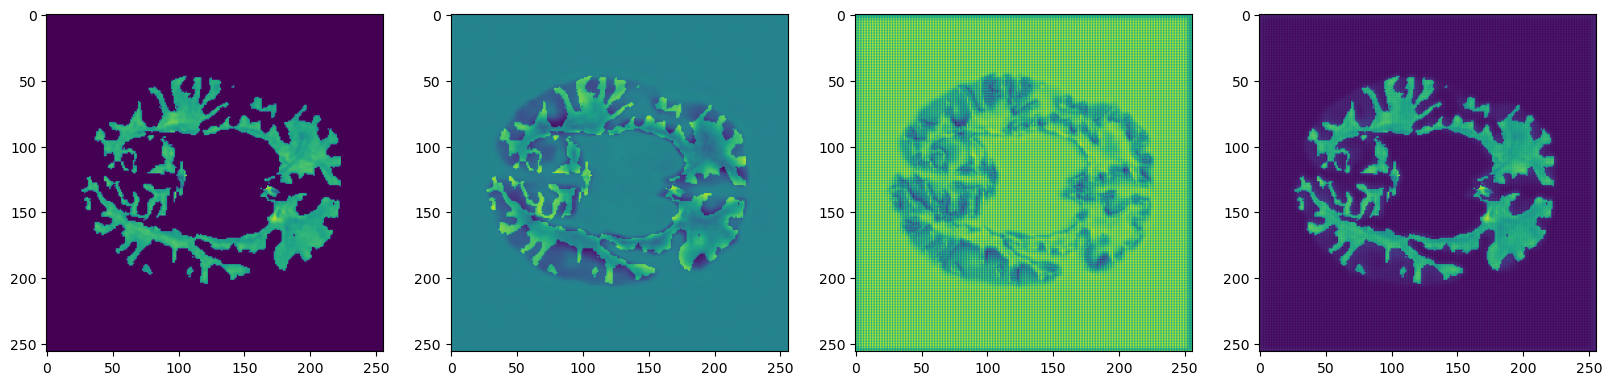

In [65]:
idx = 0
og = train[idx]["og"].reshape((256, 256))
res = train[idx]["res"].reshape((256, 256))

output = model(torch.Tensor(res).reshape((1, 1, 256, 256)).cuda())
output = output.detach().cpu().reshape((256, 256)).numpy()

fig, ax = plt.subplots(1, 4, figsize=(20,20))

ax[0].imshow(og)
ax[1].imshow(res)
ax[2].imshow(output)
ax[3].imshow(og - output)

D:\school\research\code\explore_again\modeling\vae\visualization.py:89: UserWarning: Trying to register the cmap 'above_mean' which already exists.
  plt.register_cmap(cmap=map_object)
D:\school\research\code\explore_again\modeling\vae\visualization.py:96: UserWarning: Trying to register the cmap 'below_mean' which already exists.
  plt.register_cmap(cmap=map_object)


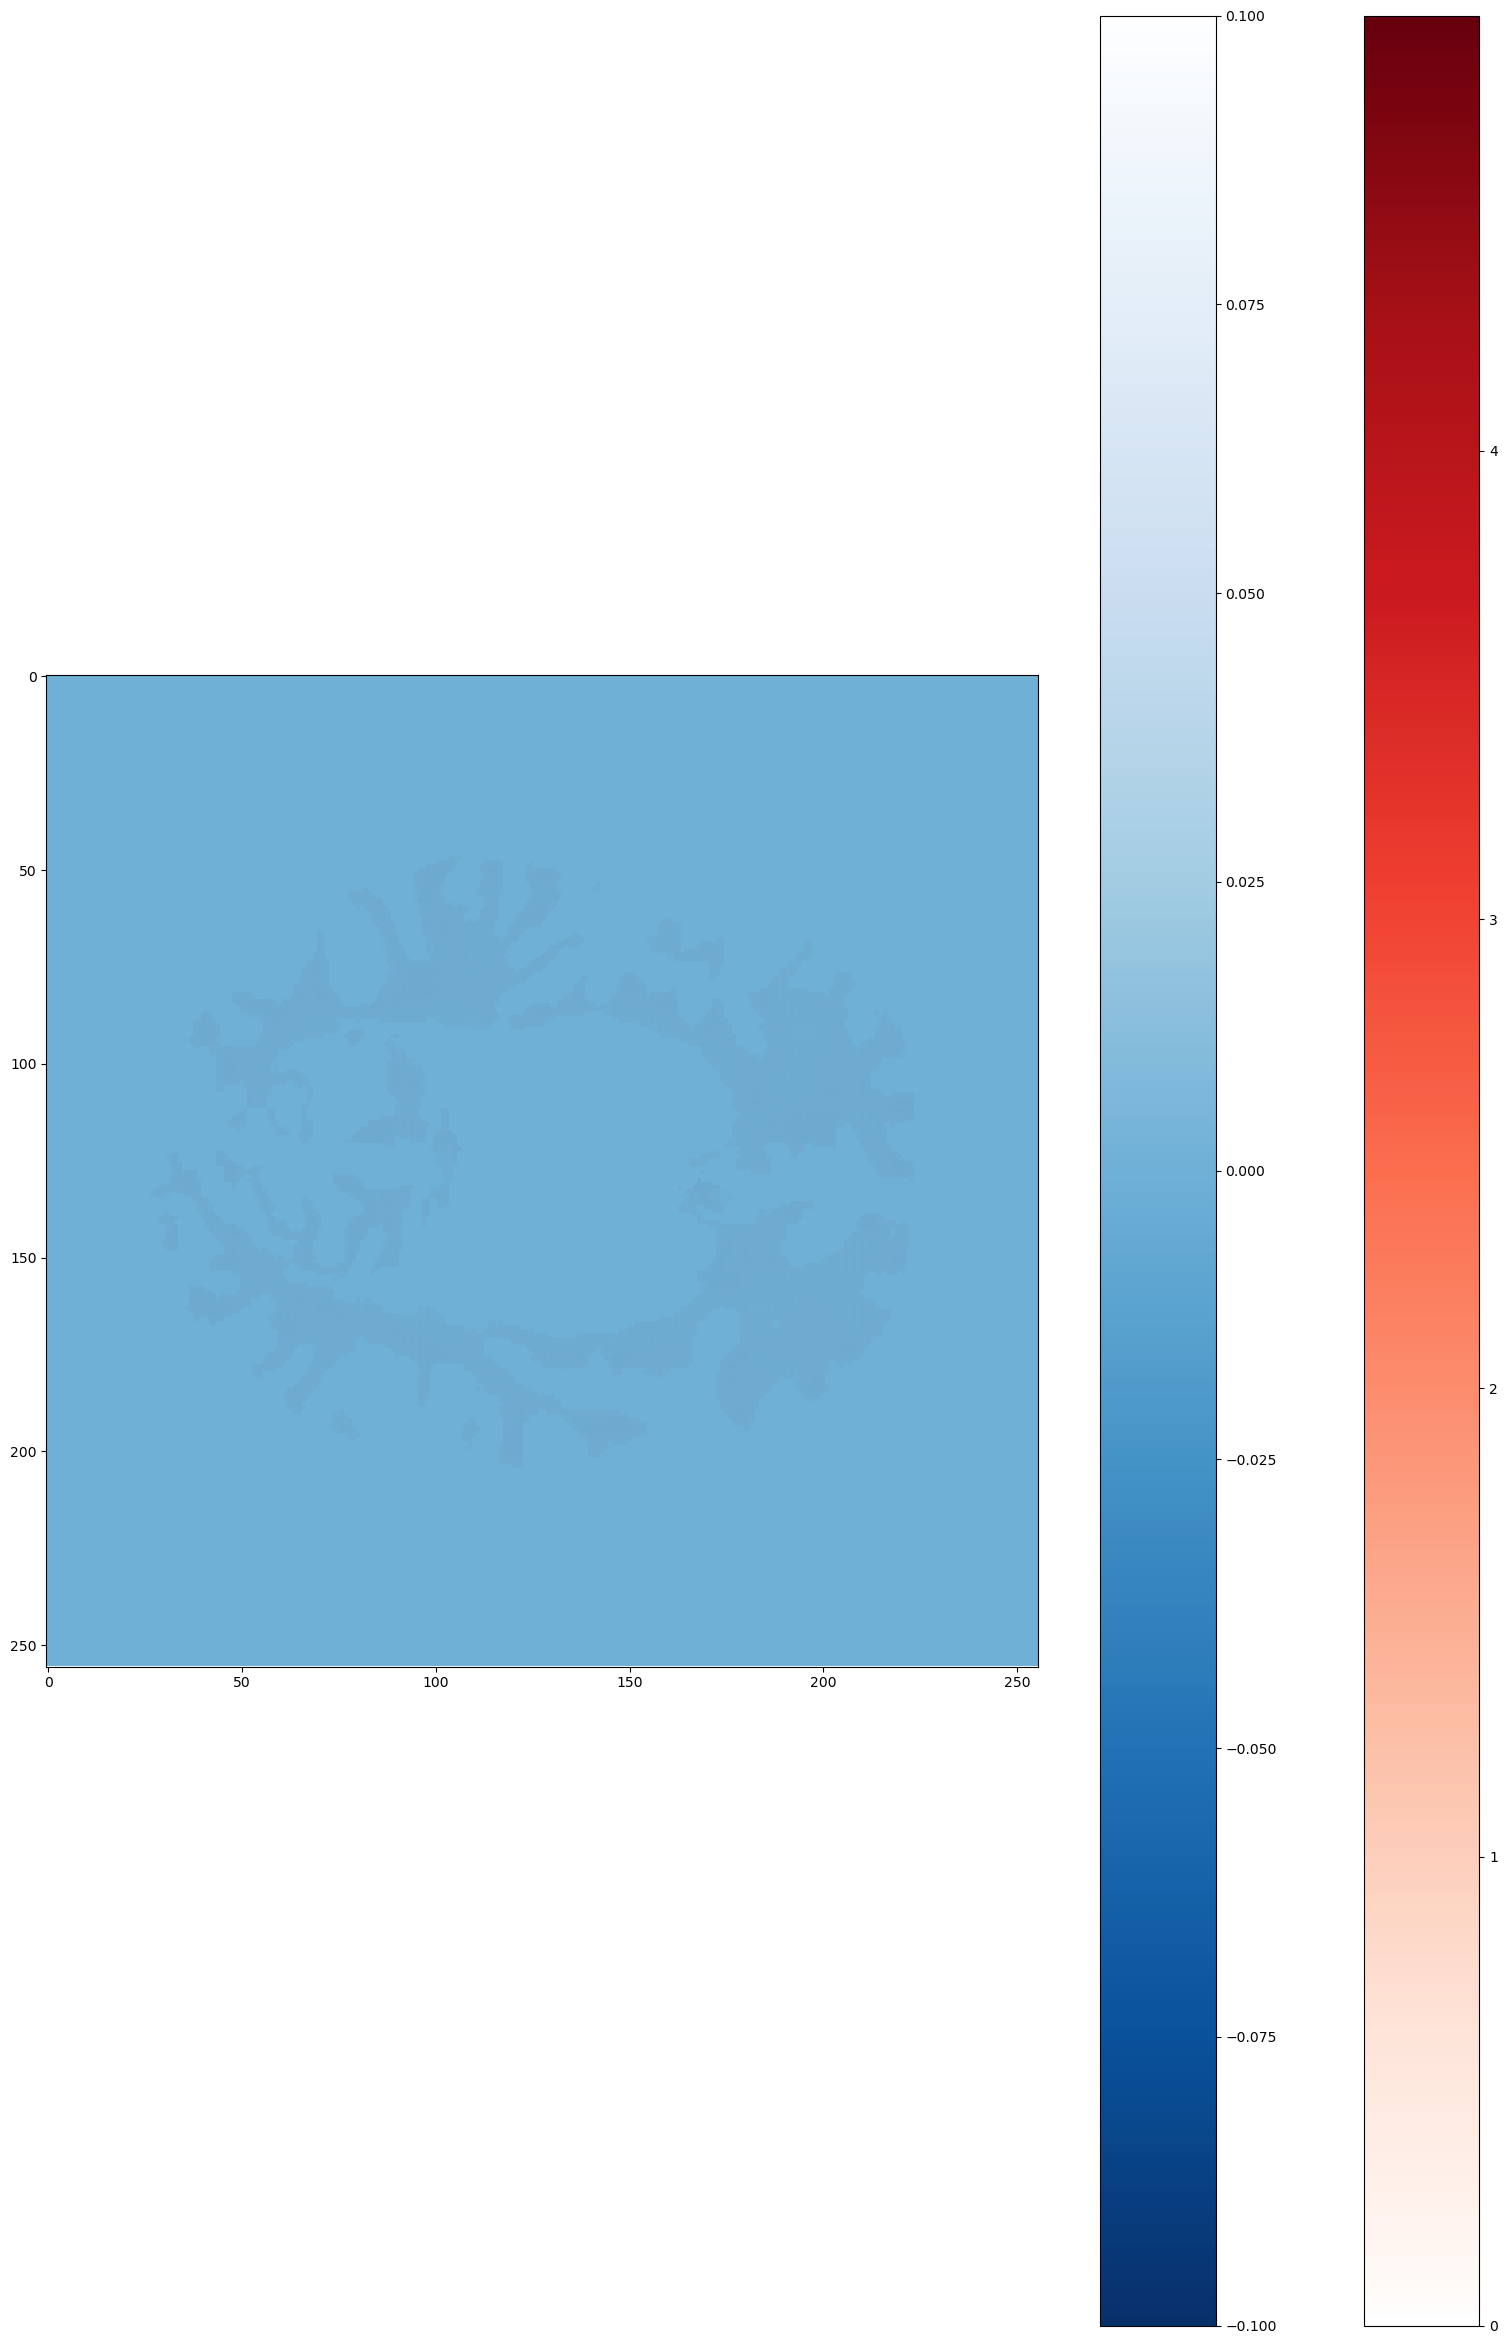

In [69]:
brain_diff(og, output, threshold=2)

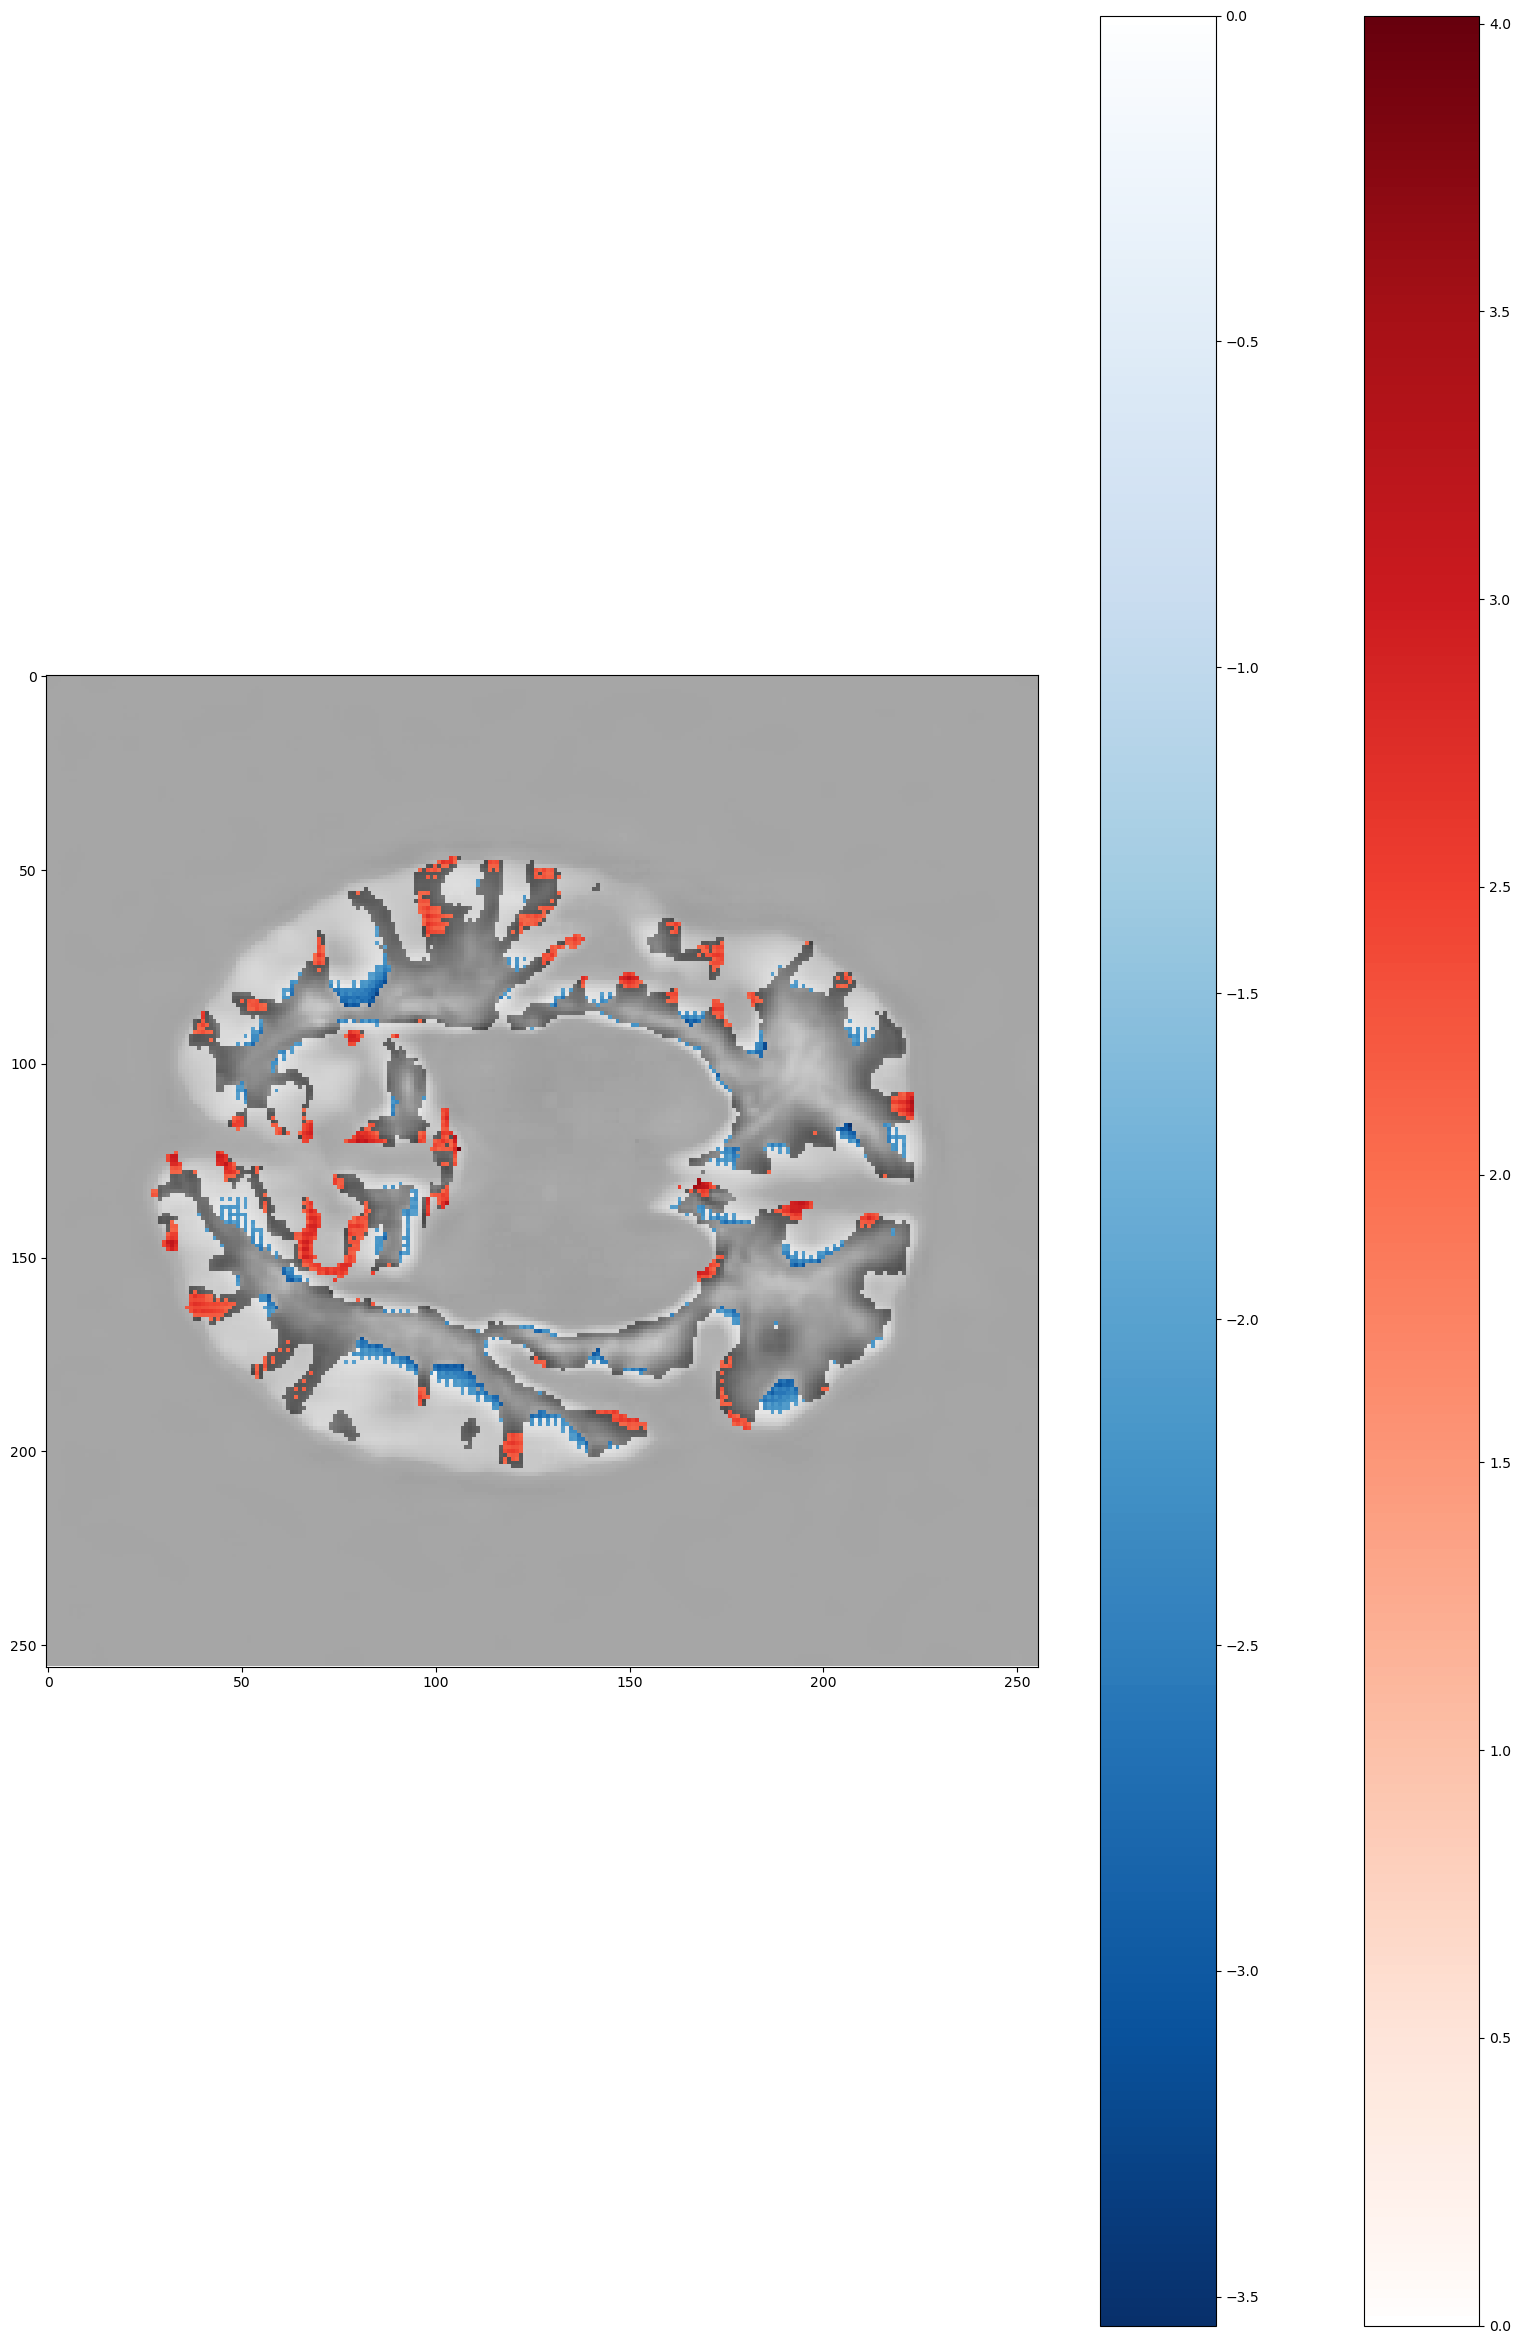

In [70]:
brain_diff(res, output, threshold=2)

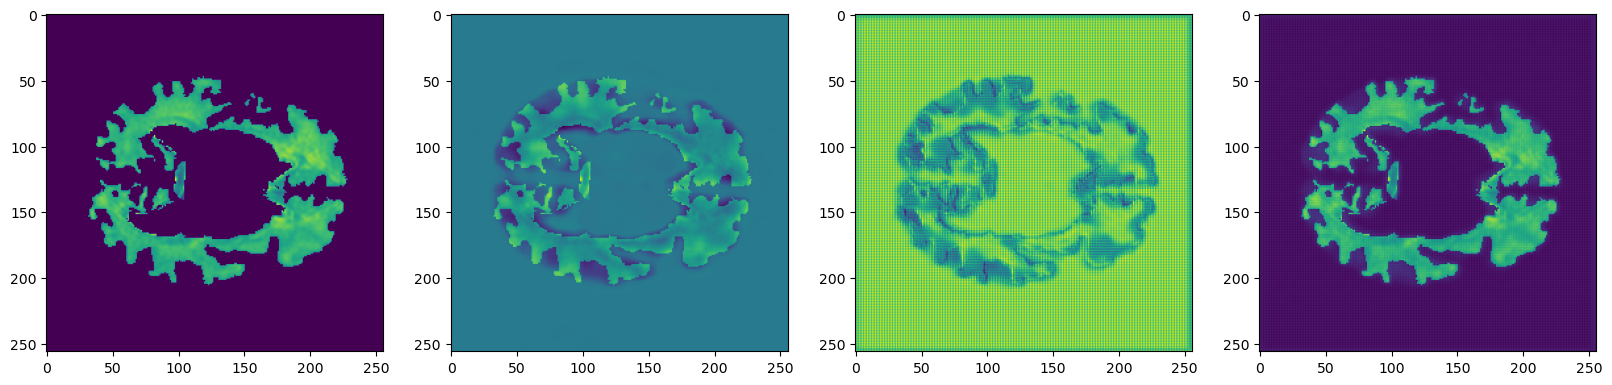

In [71]:
idx = 0
og = val[idx]["og"].reshape((256, 256))
res = val[idx]["res"].reshape((256, 256))

output = model(torch.Tensor(res).reshape((1, 1, 256, 256)).cuda())
output = output.detach().cpu().reshape((256, 256)).numpy()

fig, ax = plt.subplots(1, 4, figsize=(20,20))

ax[0].imshow(og)
ax[1].imshow(res)
ax[2].imshow(output)
ax[3].imshow(og - output)

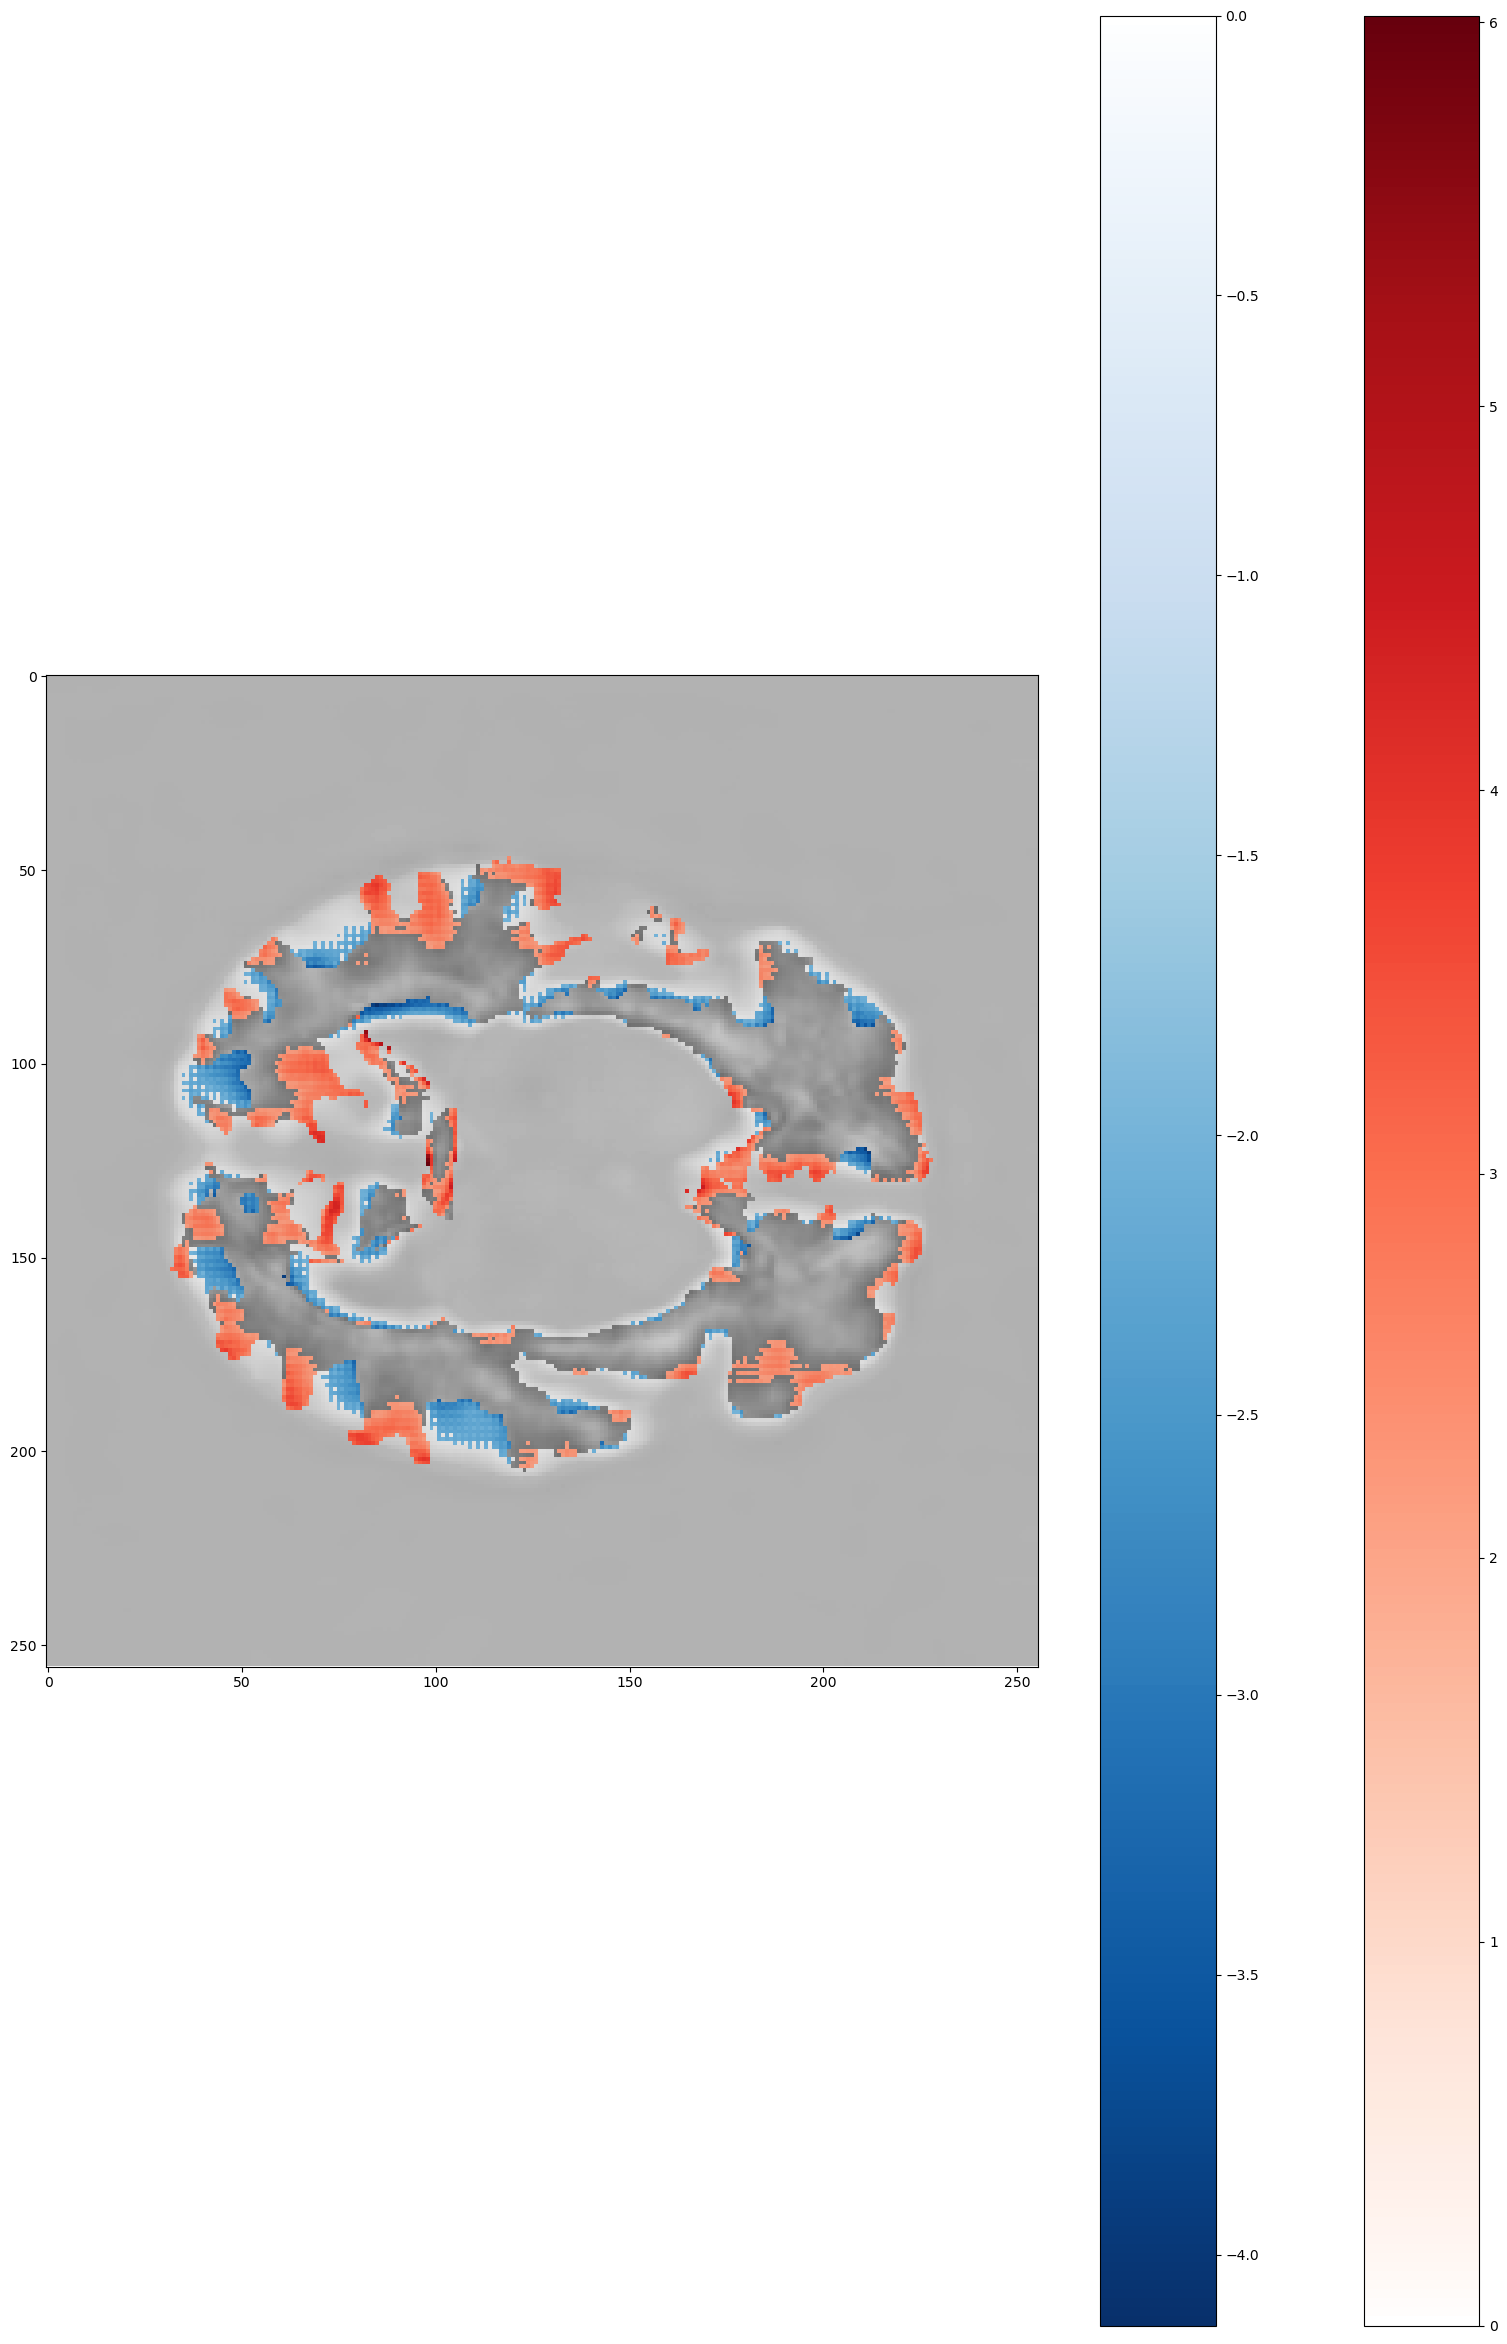

In [78]:
brain_diff(res, output, threshold=2)

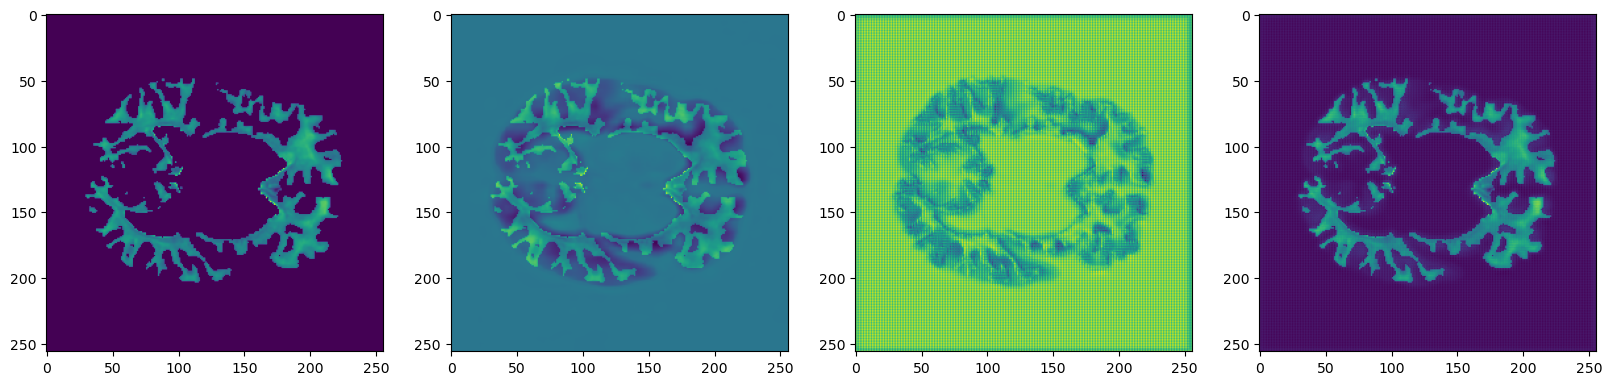

In [79]:
idx = 0
og = test[idx]["og"].reshape((256, 256))
res = test[idx]["res"].reshape((256, 256))

output = model(torch.Tensor(res).reshape((1, 1, 256, 256)).cuda())
output = output.detach().cpu().reshape((256, 256)).numpy()

fig, ax = plt.subplots(1, 4, figsize=(20,20))

ax[0].imshow(og)
ax[1].imshow(res)
ax[2].imshow(output)
ax[3].imshow(og - output)

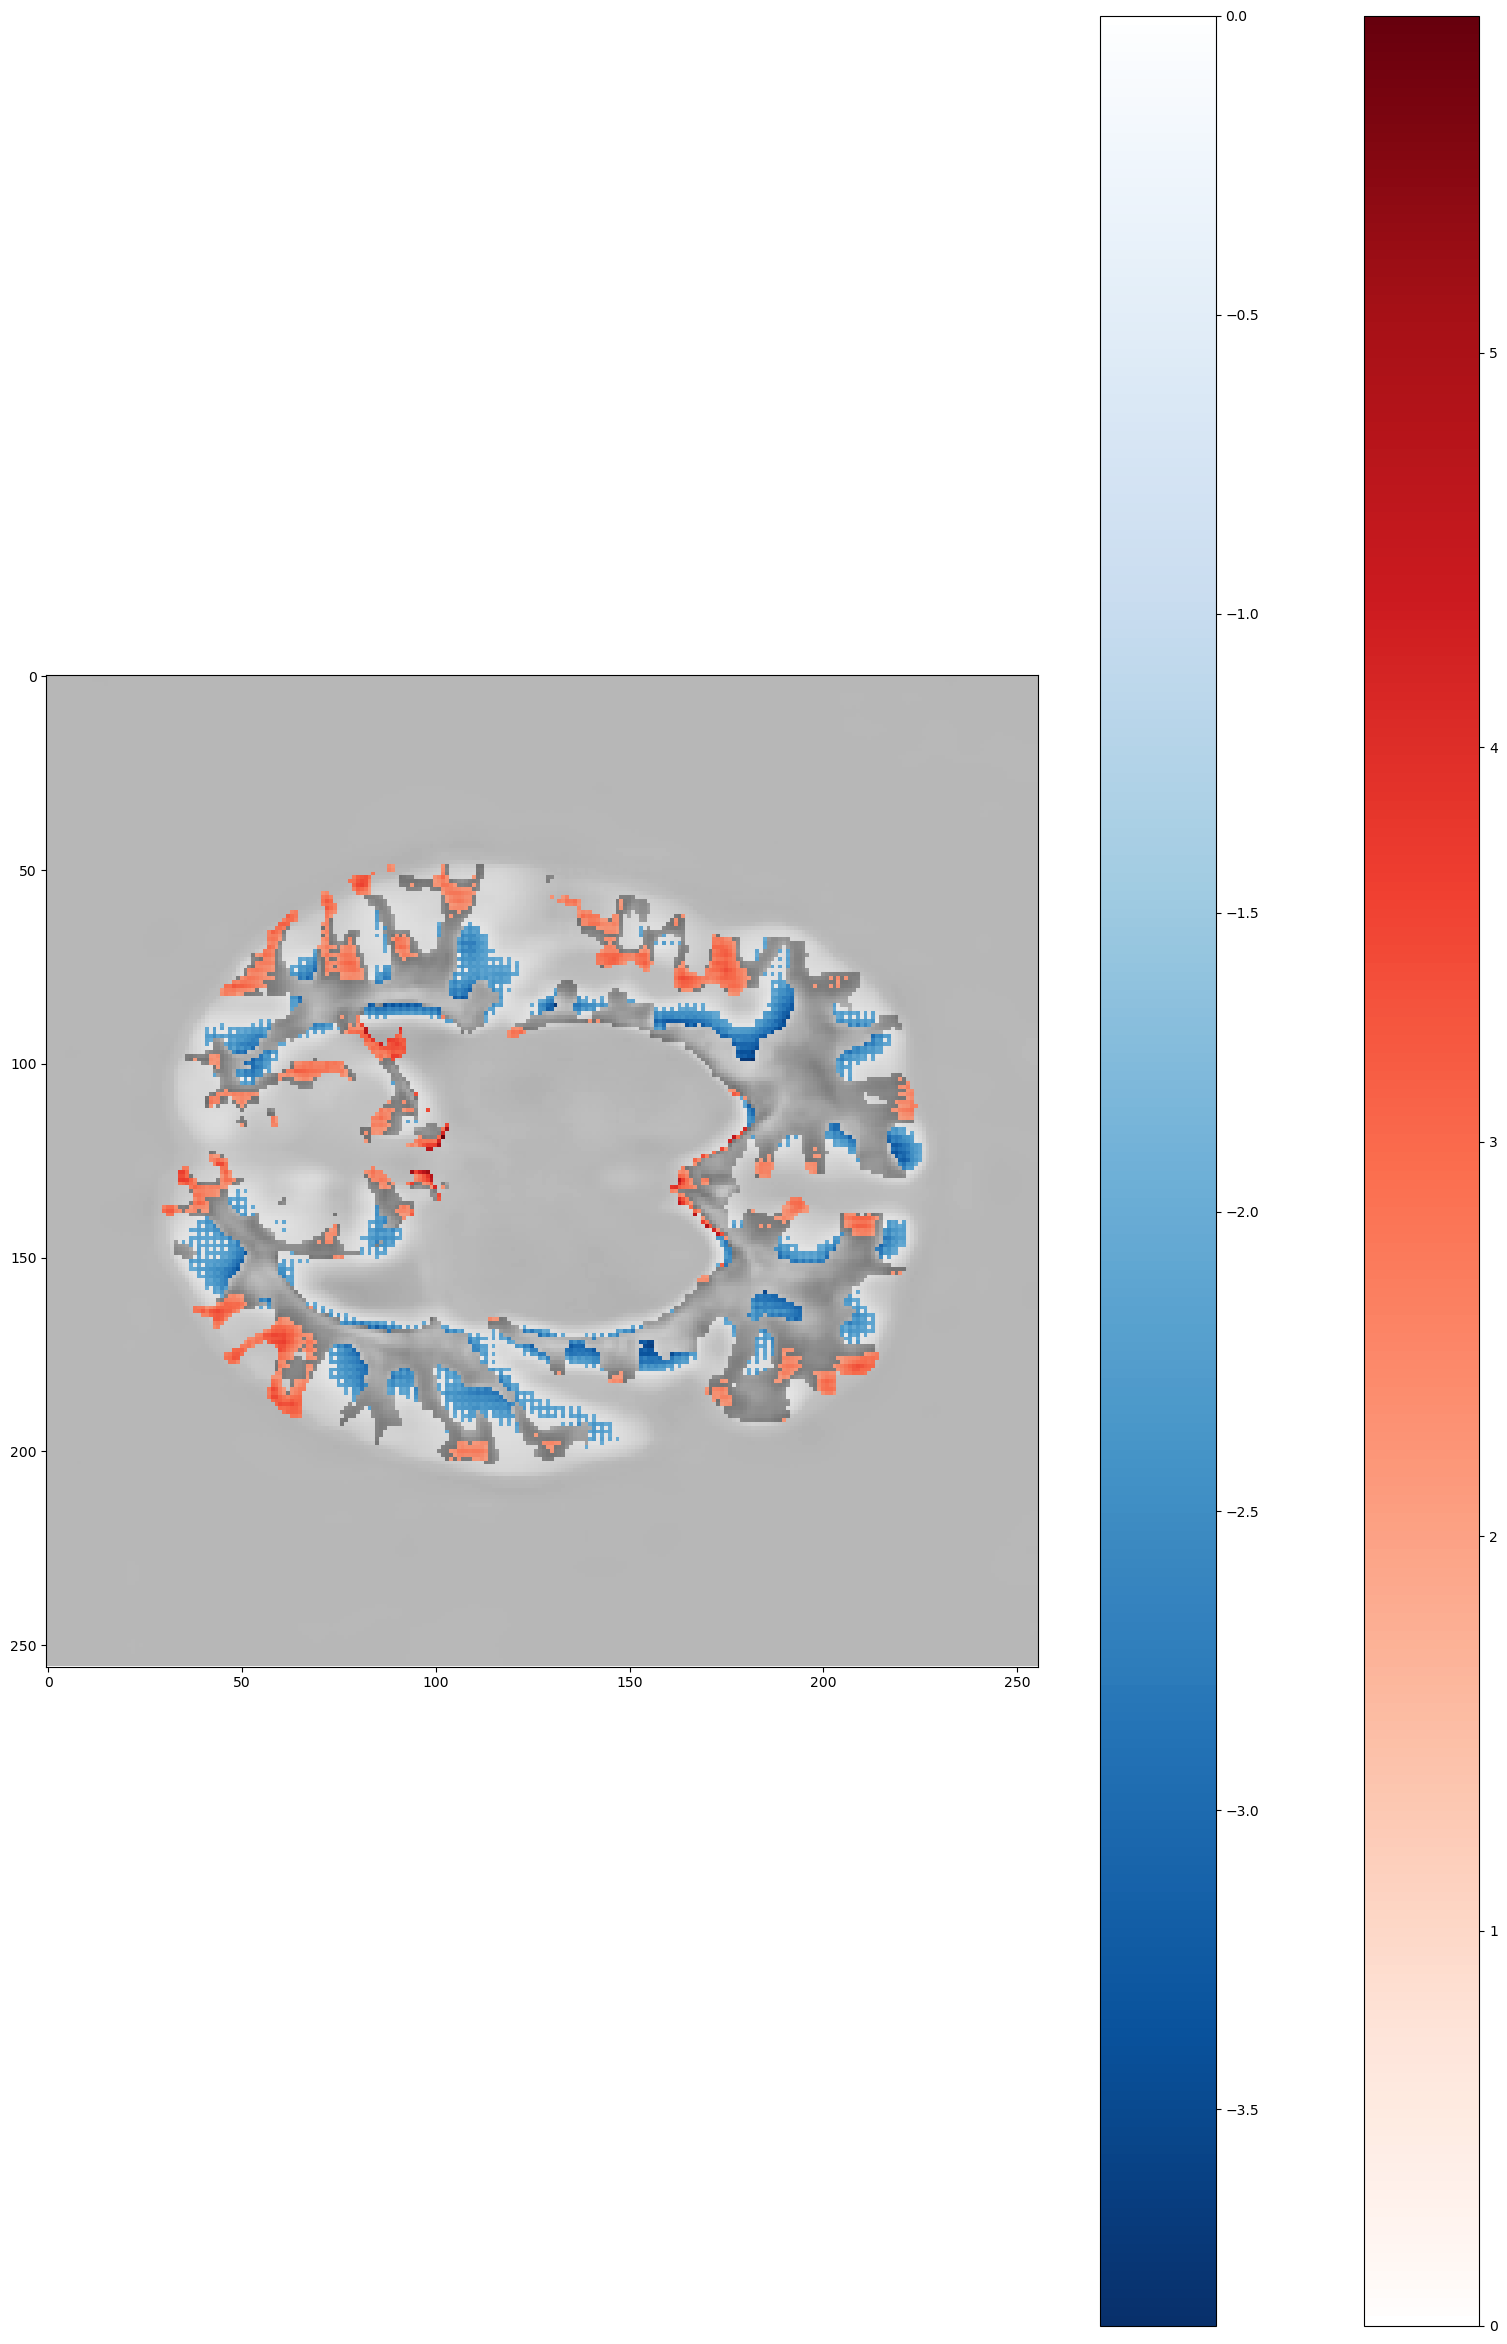

In [82]:
brain_diff(res, output, threshold=2)

### VAE on Cortical Grey Matter Residuals

In [135]:
### This initializes a minier unet with the ground truth in and out
model = VAE(1)

model.cuda()
criterion = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=1e-07)

num_epochs = 100
for epoch in range(num_epochs):
    total_loss = 0
    with tqdm(train_loader, unit="batch", ascii=' >=') as tepoch:
        model.train()
        data_counter = 0
        for data in tepoch:
            optimizer.zero_grad()
            
            og = data["og"].cuda()
            residual = data["res"].cuda()

            output = model(residual)
            loss = criterion(og, output)

            # backward
            loss.backward()
            optimizer.step()

            total_loss += loss.data
            data_counter += 1

        total_loss /= (data_counter)
        
        tepoch.set_postfix(loss=loss.item())
        val_loss = 0
        model.eval()
        data_counter = 0
        for data in val_loader:
            with torch.no_grad():
                og = data["og"].cuda()
                residual = data["res"].cuda()

                output = model(residual)
                loss = criterion(og, output)

                val_loss += loss.data
                data_counter += 1
        
        val_loss /= data_counter
        
        
        print('epoch [{}/{}], train_loss:{:.4f}, val_loss:{:.4f}'
              .format(epoch+1, num_epochs, total_loss, val_loss))

100%|=================================================================================| 6/6 [00:00<00:00, 11.58batch/s]


epoch [1/100], train_loss:0.3906, val_loss:0.6032


100%|=================================================================================| 6/6 [00:00<00:00, 11.48batch/s]


epoch [2/100], train_loss:0.1178, val_loss:0.5647


100%|=================================================================================| 6/6 [00:00<00:00, 11.52batch/s]


epoch [3/100], train_loss:0.0630, val_loss:0.2737


100%|=================================================================================| 6/6 [00:00<00:00, 11.43batch/s]


epoch [4/100], train_loss:0.0404, val_loss:0.0902


100%|=================================================================================| 6/6 [00:00<00:00, 11.14batch/s]


epoch [5/100], train_loss:0.0234, val_loss:0.0388


100%|=================================================================================| 6/6 [00:00<00:00, 11.74batch/s]


epoch [6/100], train_loss:0.0207, val_loss:0.0247


100%|=================================================================================| 6/6 [00:00<00:00, 11.19batch/s]


epoch [7/100], train_loss:0.0161, val_loss:0.0189


100%|=================================================================================| 6/6 [00:00<00:00, 11.33batch/s]


epoch [8/100], train_loss:0.0150, val_loss:0.0156


100%|=================================================================================| 6/6 [00:00<00:00, 11.32batch/s]


epoch [9/100], train_loss:0.0139, val_loss:0.0143


100%|=================================================================================| 6/6 [00:00<00:00, 11.44batch/s]


epoch [10/100], train_loss:0.0133, val_loss:0.0138


100%|=================================================================================| 6/6 [00:00<00:00, 11.45batch/s]


epoch [11/100], train_loss:0.0130, val_loss:0.0135


100%|=================================================================================| 6/6 [00:00<00:00, 11.23batch/s]


epoch [12/100], train_loss:0.0127, val_loss:0.0133


100%|=================================================================================| 6/6 [00:00<00:00, 11.45batch/s]


epoch [13/100], train_loss:0.0125, val_loss:0.0131


100%|=================================================================================| 6/6 [00:00<00:00, 11.48batch/s]


epoch [14/100], train_loss:0.0124, val_loss:0.0130


100%|=================================================================================| 6/6 [00:00<00:00, 11.58batch/s]


epoch [15/100], train_loss:0.0123, val_loss:0.0129


100%|=================================================================================| 6/6 [00:00<00:00, 11.03batch/s]


epoch [16/100], train_loss:0.0122, val_loss:0.0128


100%|=================================================================================| 6/6 [00:00<00:00, 11.53batch/s]


epoch [17/100], train_loss:0.0121, val_loss:0.0127


100%|=================================================================================| 6/6 [00:00<00:00, 11.45batch/s]


epoch [18/100], train_loss:0.0120, val_loss:0.0127


100%|=================================================================================| 6/6 [00:00<00:00, 10.94batch/s]


epoch [19/100], train_loss:0.0119, val_loss:0.0125


100%|=================================================================================| 6/6 [00:00<00:00, 11.29batch/s]


epoch [20/100], train_loss:0.0117, val_loss:0.0123


100%|=================================================================================| 6/6 [00:00<00:00, 11.41batch/s]


epoch [21/100], train_loss:0.0114, val_loss:0.0124


100%|=================================================================================| 6/6 [00:00<00:00, 11.25batch/s]


epoch [22/100], train_loss:0.0110, val_loss:0.0123


100%|=================================================================================| 6/6 [00:00<00:00, 11.40batch/s]


epoch [23/100], train_loss:0.0102, val_loss:0.0108


100%|=================================================================================| 6/6 [00:00<00:00, 10.96batch/s]


epoch [24/100], train_loss:0.0094, val_loss:0.0097


100%|=================================================================================| 6/6 [00:00<00:00, 11.06batch/s]


epoch [25/100], train_loss:0.0088, val_loss:0.0093


100%|=================================================================================| 6/6 [00:00<00:00, 11.35batch/s]


epoch [26/100], train_loss:0.0083, val_loss:0.0092


100%|=================================================================================| 6/6 [00:00<00:00, 10.61batch/s]


epoch [27/100], train_loss:0.0079, val_loss:0.0092


100%|=================================================================================| 6/6 [00:00<00:00, 11.09batch/s]


epoch [28/100], train_loss:0.0076, val_loss:0.0089


100%|=================================================================================| 6/6 [00:00<00:00, 11.18batch/s]


epoch [29/100], train_loss:0.0075, val_loss:0.0078


100%|=================================================================================| 6/6 [00:00<00:00, 11.25batch/s]


epoch [30/100], train_loss:0.0074, val_loss:0.0076


100%|=================================================================================| 6/6 [00:00<00:00, 11.37batch/s]


epoch [31/100], train_loss:0.0072, val_loss:0.0075


100%|=================================================================================| 6/6 [00:00<00:00, 11.68batch/s]


epoch [32/100], train_loss:0.0071, val_loss:0.0073


100%|=================================================================================| 6/6 [00:00<00:00, 10.76batch/s]


epoch [33/100], train_loss:0.0071, val_loss:0.0073


100%|=================================================================================| 6/6 [00:00<00:00, 11.55batch/s]


epoch [34/100], train_loss:0.0070, val_loss:0.0073


100%|=================================================================================| 6/6 [00:00<00:00, 11.47batch/s]


epoch [35/100], train_loss:0.0070, val_loss:0.0072


100%|=================================================================================| 6/6 [00:00<00:00, 11.30batch/s]


epoch [36/100], train_loss:0.0070, val_loss:0.0073


100%|=================================================================================| 6/6 [00:00<00:00, 11.39batch/s]


epoch [37/100], train_loss:0.0070, val_loss:0.0072


100%|=================================================================================| 6/6 [00:00<00:00, 11.36batch/s]


epoch [38/100], train_loss:0.0069, val_loss:0.0072


100%|=================================================================================| 6/6 [00:00<00:00, 11.06batch/s]


epoch [39/100], train_loss:0.0069, val_loss:0.0073


100%|=================================================================================| 6/6 [00:00<00:00, 11.39batch/s]


epoch [40/100], train_loss:0.0069, val_loss:0.0072


100%|=================================================================================| 6/6 [00:00<00:00, 11.23batch/s]


epoch [41/100], train_loss:0.0069, val_loss:0.0071


100%|=================================================================================| 6/6 [00:00<00:00, 11.47batch/s]


epoch [42/100], train_loss:0.0068, val_loss:0.0070


100%|=================================================================================| 6/6 [00:00<00:00, 11.70batch/s]


epoch [43/100], train_loss:0.0068, val_loss:0.0071


100%|=================================================================================| 6/6 [00:00<00:00, 10.81batch/s]


epoch [44/100], train_loss:0.0068, val_loss:0.0071


100%|=================================================================================| 6/6 [00:00<00:00, 11.27batch/s]


epoch [45/100], train_loss:0.0067, val_loss:0.0069


100%|=================================================================================| 6/6 [00:00<00:00, 11.33batch/s]


epoch [46/100], train_loss:0.0067, val_loss:0.0069


100%|=================================================================================| 6/6 [00:00<00:00, 11.19batch/s]


epoch [47/100], train_loss:0.0066, val_loss:0.0069


100%|=================================================================================| 6/6 [00:00<00:00, 11.46batch/s]


epoch [48/100], train_loss:0.0067, val_loss:0.0070


100%|=================================================================================| 6/6 [00:00<00:00, 11.64batch/s]


epoch [49/100], train_loss:0.0066, val_loss:0.0069


100%|=================================================================================| 6/6 [00:00<00:00, 11.35batch/s]


epoch [50/100], train_loss:0.0066, val_loss:0.0069


100%|=================================================================================| 6/6 [00:00<00:00, 11.51batch/s]


epoch [51/100], train_loss:0.0066, val_loss:0.0068


100%|=================================================================================| 6/6 [00:00<00:00, 11.31batch/s]


epoch [52/100], train_loss:0.0066, val_loss:0.0069


100%|=================================================================================| 6/6 [00:00<00:00, 11.13batch/s]


epoch [53/100], train_loss:0.0065, val_loss:0.0068


100%|=================================================================================| 6/6 [00:00<00:00, 11.55batch/s]


epoch [54/100], train_loss:0.0065, val_loss:0.0068


100%|=================================================================================| 6/6 [00:00<00:00, 11.27batch/s]


epoch [55/100], train_loss:0.0065, val_loss:0.0068


100%|=================================================================================| 6/6 [00:00<00:00, 11.02batch/s]


epoch [56/100], train_loss:0.0065, val_loss:0.0068


100%|=================================================================================| 6/6 [00:00<00:00, 11.62batch/s]


epoch [57/100], train_loss:0.0065, val_loss:0.0068


100%|=================================================================================| 6/6 [00:00<00:00, 11.08batch/s]


epoch [58/100], train_loss:0.0065, val_loss:0.0068


100%|=================================================================================| 6/6 [00:00<00:00, 11.35batch/s]


epoch [59/100], train_loss:0.0065, val_loss:0.0068


100%|=================================================================================| 6/6 [00:00<00:00, 11.44batch/s]


epoch [60/100], train_loss:0.0065, val_loss:0.0068


100%|=================================================================================| 6/6 [00:00<00:00, 11.16batch/s]


epoch [61/100], train_loss:0.0065, val_loss:0.0068


100%|=================================================================================| 6/6 [00:00<00:00, 10.60batch/s]


epoch [62/100], train_loss:0.0064, val_loss:0.0067


100%|=================================================================================| 6/6 [00:00<00:00, 11.39batch/s]


epoch [63/100], train_loss:0.0064, val_loss:0.0067


100%|=================================================================================| 6/6 [00:00<00:00, 11.37batch/s]


epoch [64/100], train_loss:0.0064, val_loss:0.0067


100%|=================================================================================| 6/6 [00:00<00:00, 11.25batch/s]


epoch [65/100], train_loss:0.0065, val_loss:0.0067


100%|=================================================================================| 6/6 [00:00<00:00, 11.33batch/s]


epoch [66/100], train_loss:0.0064, val_loss:0.0068


100%|=================================================================================| 6/6 [00:00<00:00, 11.18batch/s]


epoch [67/100], train_loss:0.0064, val_loss:0.0067


100%|=================================================================================| 6/6 [00:00<00:00, 11.13batch/s]


epoch [68/100], train_loss:0.0064, val_loss:0.0066


100%|=================================================================================| 6/6 [00:00<00:00, 11.46batch/s]


epoch [69/100], train_loss:0.0064, val_loss:0.0067


100%|=================================================================================| 6/6 [00:00<00:00, 10.69batch/s]


epoch [70/100], train_loss:0.0064, val_loss:0.0066


100%|=================================================================================| 6/6 [00:00<00:00, 11.59batch/s]


epoch [71/100], train_loss:0.0065, val_loss:0.0070


100%|=================================================================================| 6/6 [00:00<00:00, 11.23batch/s]


epoch [72/100], train_loss:0.0065, val_loss:0.0067


100%|=================================================================================| 6/6 [00:00<00:00, 11.34batch/s]


epoch [73/100], train_loss:0.0064, val_loss:0.0068


100%|=================================================================================| 6/6 [00:00<00:00, 11.61batch/s]


epoch [74/100], train_loss:0.0064, val_loss:0.0067


100%|=================================================================================| 6/6 [00:00<00:00, 11.46batch/s]


epoch [75/100], train_loss:0.0064, val_loss:0.0068


100%|=================================================================================| 6/6 [00:00<00:00, 11.42batch/s]


epoch [76/100], train_loss:0.0064, val_loss:0.0068


100%|=================================================================================| 6/6 [00:00<00:00, 11.08batch/s]


epoch [77/100], train_loss:0.0065, val_loss:0.0068


100%|=================================================================================| 6/6 [00:00<00:00, 11.23batch/s]


epoch [78/100], train_loss:0.0064, val_loss:0.0066


100%|=================================================================================| 6/6 [00:00<00:00, 11.36batch/s]


epoch [79/100], train_loss:0.0063, val_loss:0.0067


100%|=================================================================================| 6/6 [00:00<00:00, 11.56batch/s]


epoch [80/100], train_loss:0.0063, val_loss:0.0066


100%|=================================================================================| 6/6 [00:00<00:00, 11.29batch/s]


epoch [81/100], train_loss:0.0063, val_loss:0.0066


100%|=================================================================================| 6/6 [00:00<00:00, 11.12batch/s]


epoch [82/100], train_loss:0.0064, val_loss:0.0066


100%|=================================================================================| 6/6 [00:00<00:00, 11.53batch/s]


epoch [83/100], train_loss:0.0065, val_loss:0.0070


100%|=================================================================================| 6/6 [00:00<00:00, 10.42batch/s]


epoch [84/100], train_loss:0.0064, val_loss:0.0066


100%|=================================================================================| 6/6 [00:00<00:00, 10.83batch/s]


epoch [85/100], train_loss:0.0063, val_loss:0.0067


100%|=================================================================================| 6/6 [00:00<00:00, 11.35batch/s]


epoch [86/100], train_loss:0.0065, val_loss:0.0070


100%|=================================================================================| 6/6 [00:00<00:00, 10.84batch/s]


epoch [87/100], train_loss:0.0076, val_loss:0.0122


100%|=================================================================================| 6/6 [00:00<00:00, 11.00batch/s]


epoch [88/100], train_loss:0.0070, val_loss:0.0083


100%|=================================================================================| 6/6 [00:00<00:00, 11.02batch/s]


epoch [89/100], train_loss:0.0068, val_loss:0.0070


100%|=================================================================================| 6/6 [00:00<00:00, 11.35batch/s]


epoch [90/100], train_loss:0.0065, val_loss:0.0066


100%|=================================================================================| 6/6 [00:00<00:00, 11.31batch/s]


epoch [91/100], train_loss:0.0064, val_loss:0.0066


100%|=================================================================================| 6/6 [00:00<00:00, 11.57batch/s]


epoch [92/100], train_loss:0.0064, val_loss:0.0065


100%|=================================================================================| 6/6 [00:00<00:00, 10.43batch/s]


epoch [93/100], train_loss:0.0063, val_loss:0.0066


100%|=================================================================================| 6/6 [00:00<00:00, 10.76batch/s]


epoch [94/100], train_loss:0.0063, val_loss:0.0065


100%|=================================================================================| 6/6 [00:00<00:00, 10.94batch/s]


epoch [95/100], train_loss:0.0063, val_loss:0.0065


100%|=================================================================================| 6/6 [00:00<00:00, 10.82batch/s]


epoch [96/100], train_loss:0.0063, val_loss:0.0065


100%|=================================================================================| 6/6 [00:00<00:00, 11.32batch/s]


epoch [97/100], train_loss:0.0063, val_loss:0.0065


100%|=================================================================================| 6/6 [00:00<00:00, 11.56batch/s]


epoch [98/100], train_loss:0.0062, val_loss:0.0065


100%|=================================================================================| 6/6 [00:00<00:00, 11.00batch/s]


epoch [99/100], train_loss:0.0062, val_loss:0.0066


100%|=================================================================================| 6/6 [00:00<00:00, 11.51batch/s]


epoch [100/100], train_loss:0.0062, val_loss:0.0065


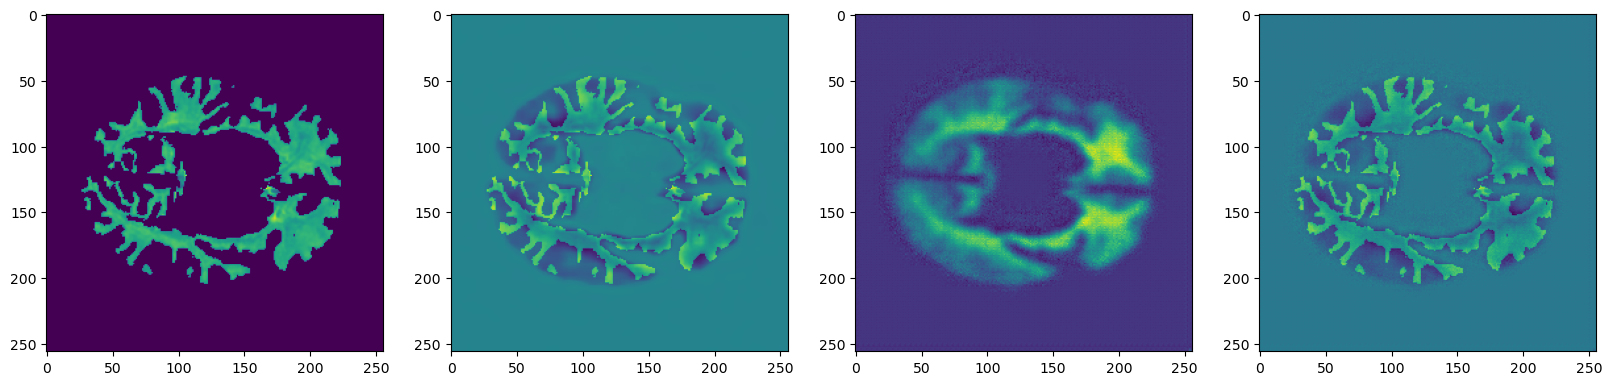

In [136]:
idx = 0
og = train[idx]["og"].reshape((256, 256))
res = train[idx]["res"].reshape((256, 256))

output = model(torch.Tensor(res).reshape((1, 1, 256, 256)).cuda())
output = output.detach().cpu().reshape((256, 256)).numpy()

fig, ax = plt.subplots(1, 4, figsize=(20,20))

ax[0].imshow(og)
ax[1].imshow(res)
ax[2].imshow(output)
ax[3].imshow(og - output)

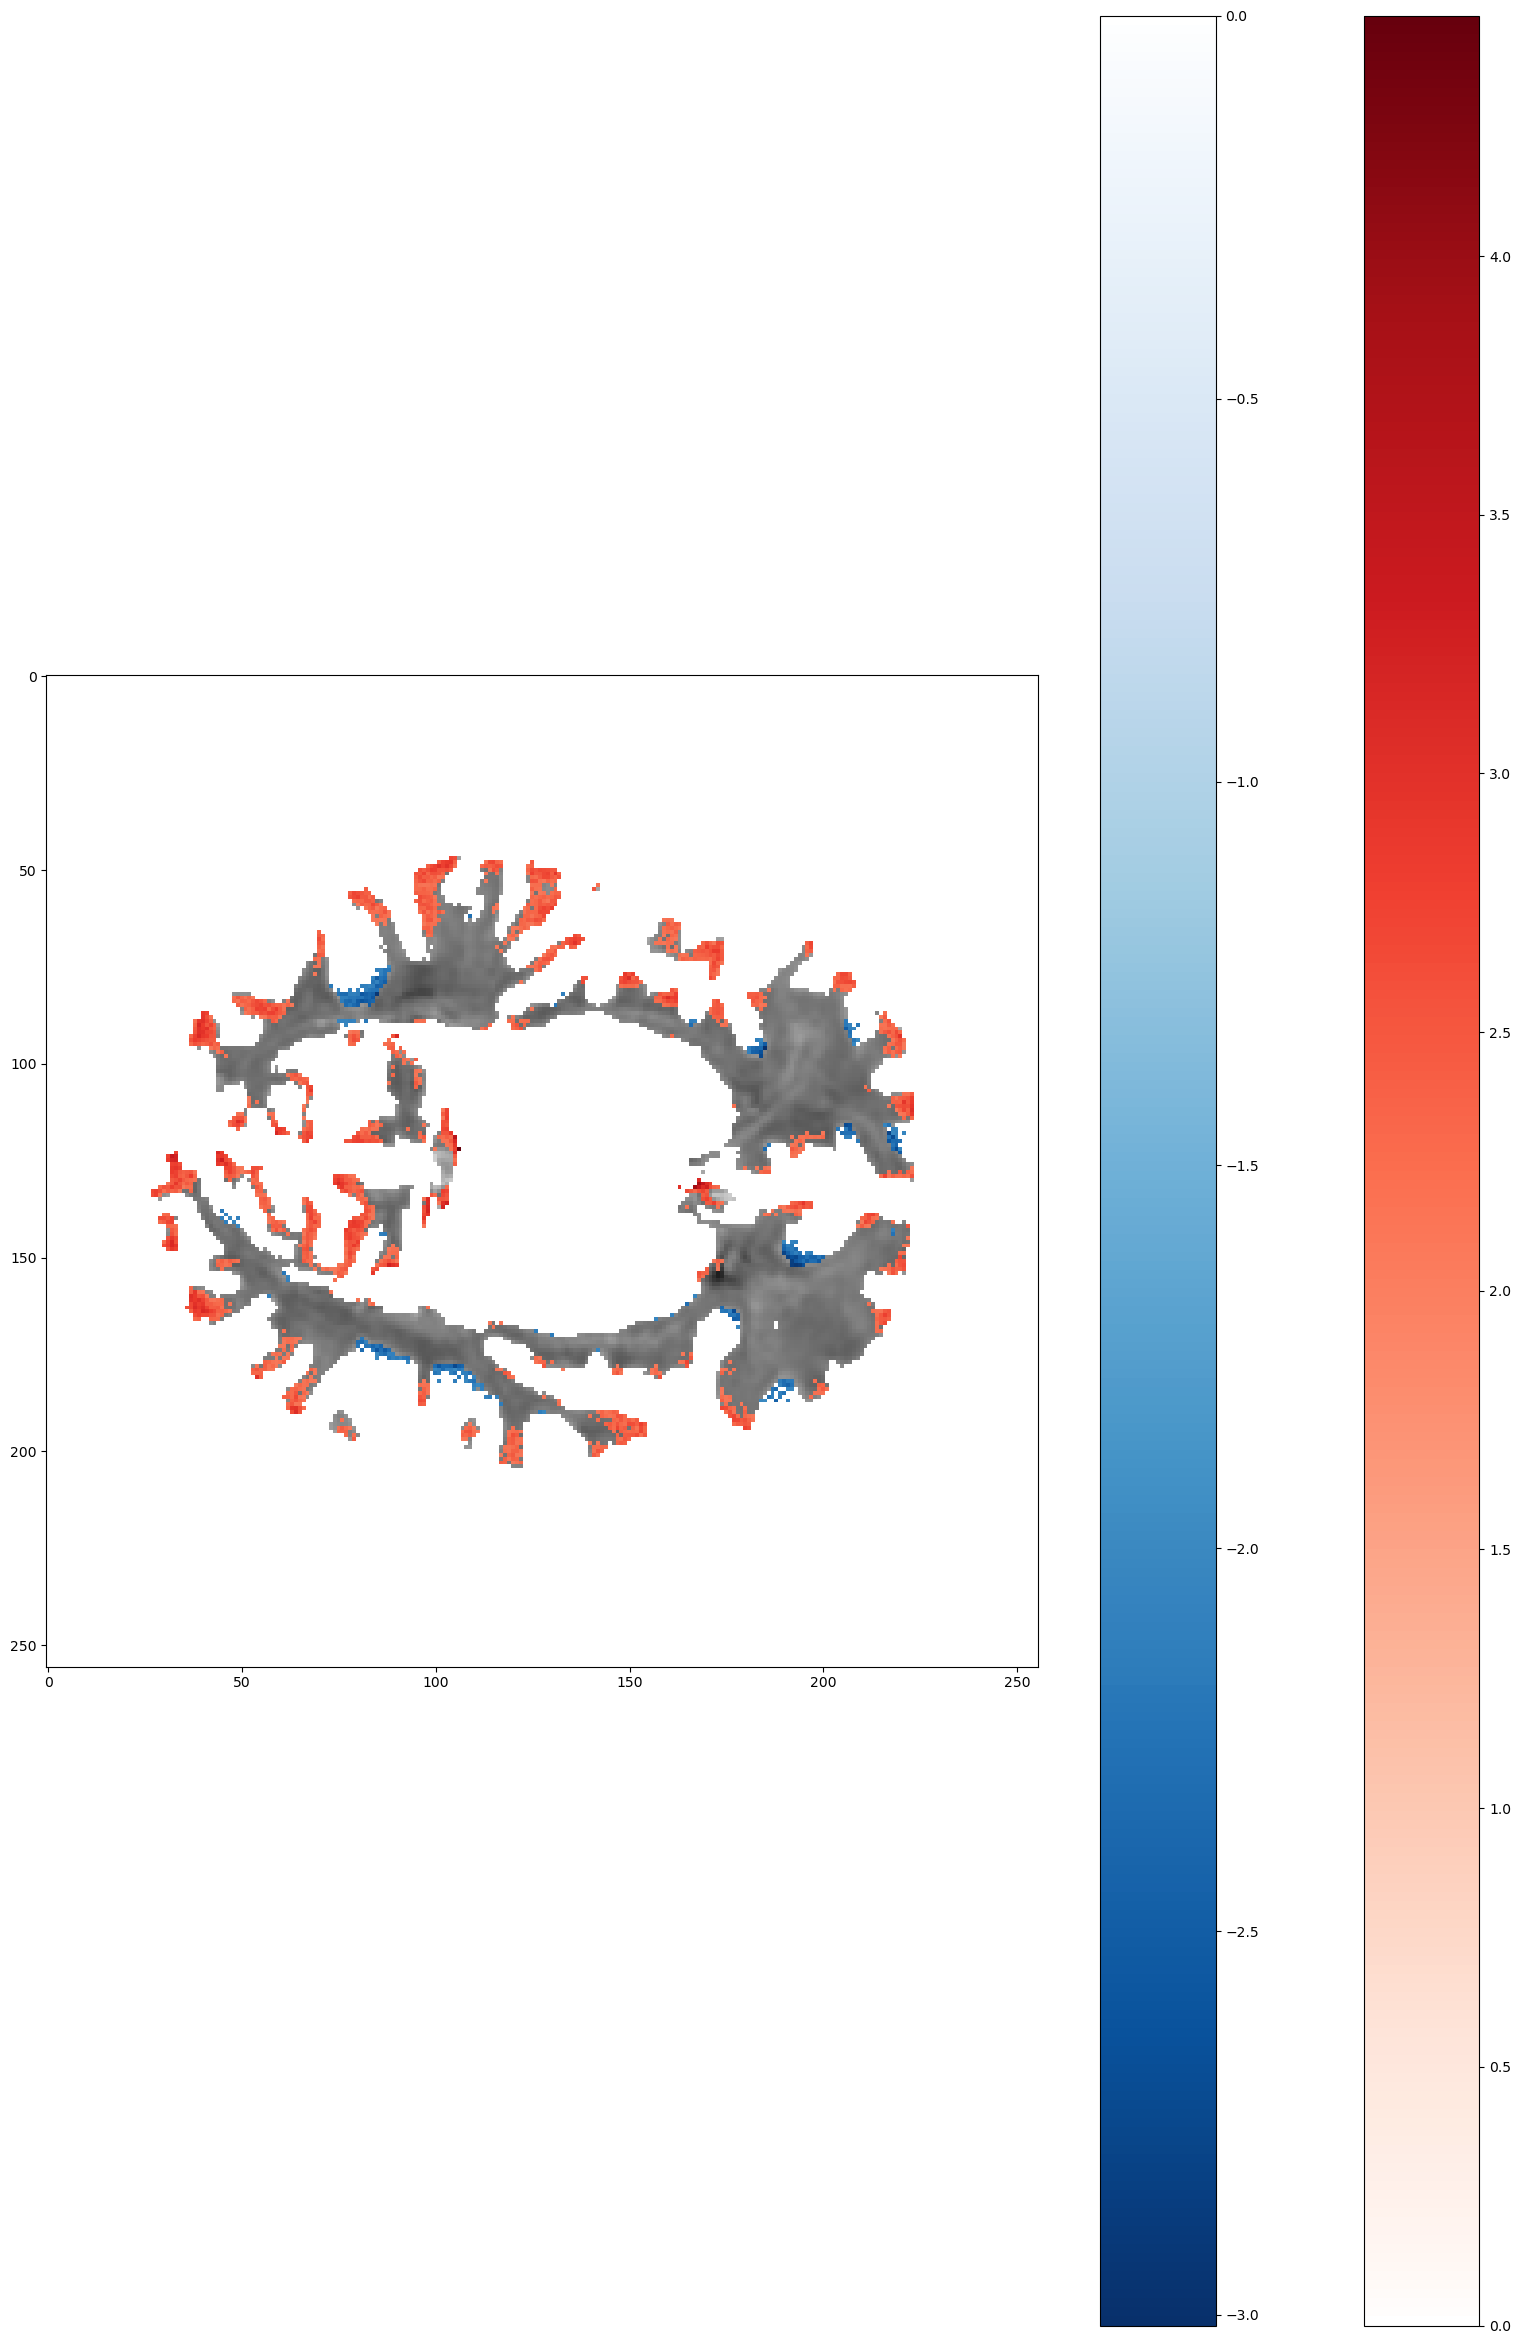

In [137]:
brain_diff(og, output, threshold=2)

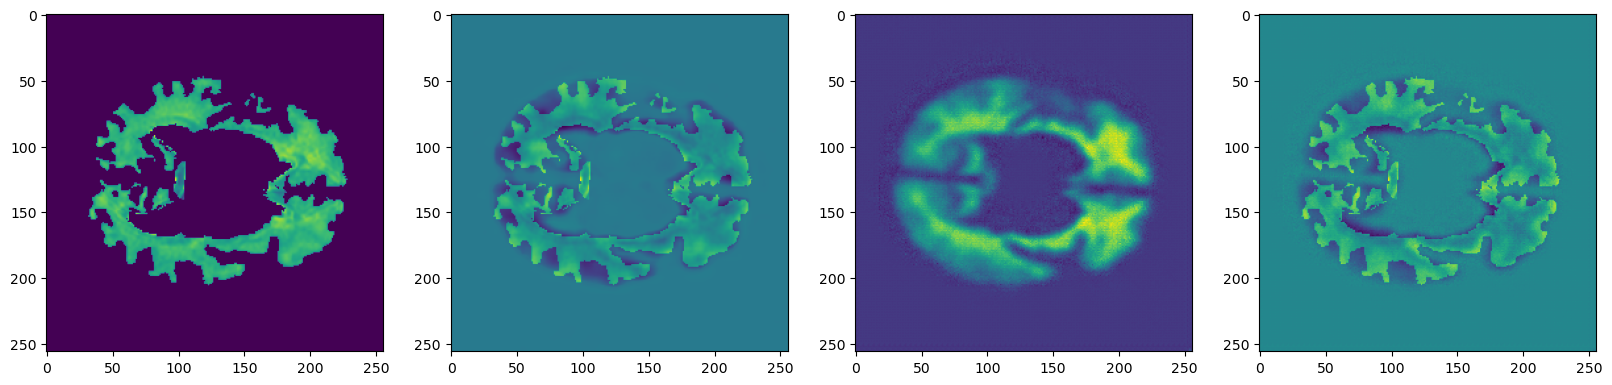

In [138]:
idx = 0
og = val[idx]["og"].reshape((256, 256))
res = val[idx]["res"].reshape((256, 256))

output = model(torch.Tensor(res).reshape((1, 1, 256, 256)).cuda())
output = output.detach().cpu().reshape((256, 256)).numpy()

fig, ax = plt.subplots(1, 4, figsize=(20,20))

ax[0].imshow(og)
ax[1].imshow(res)
ax[2].imshow(output)
ax[3].imshow(og - output)

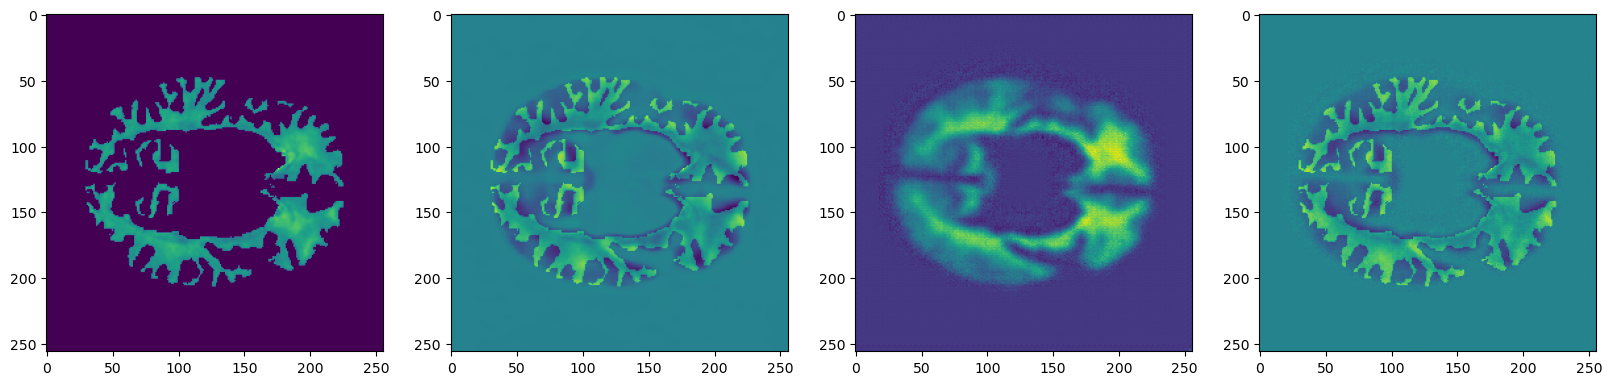

In [139]:
idx = 5
og = test[idx]["og"].reshape((256, 256))
res = test[idx]["res"].reshape((256, 256))

output = model(torch.Tensor(res).reshape((1, 1, 256, 256)).cuda())
output = output.detach().cpu().reshape((256, 256)).numpy()

fig, ax = plt.subplots(1, 4, figsize=(20,20))

ax[0].imshow(og)
ax[1].imshow(res)
ax[2].imshow(output)
ax[3].imshow(og - output)

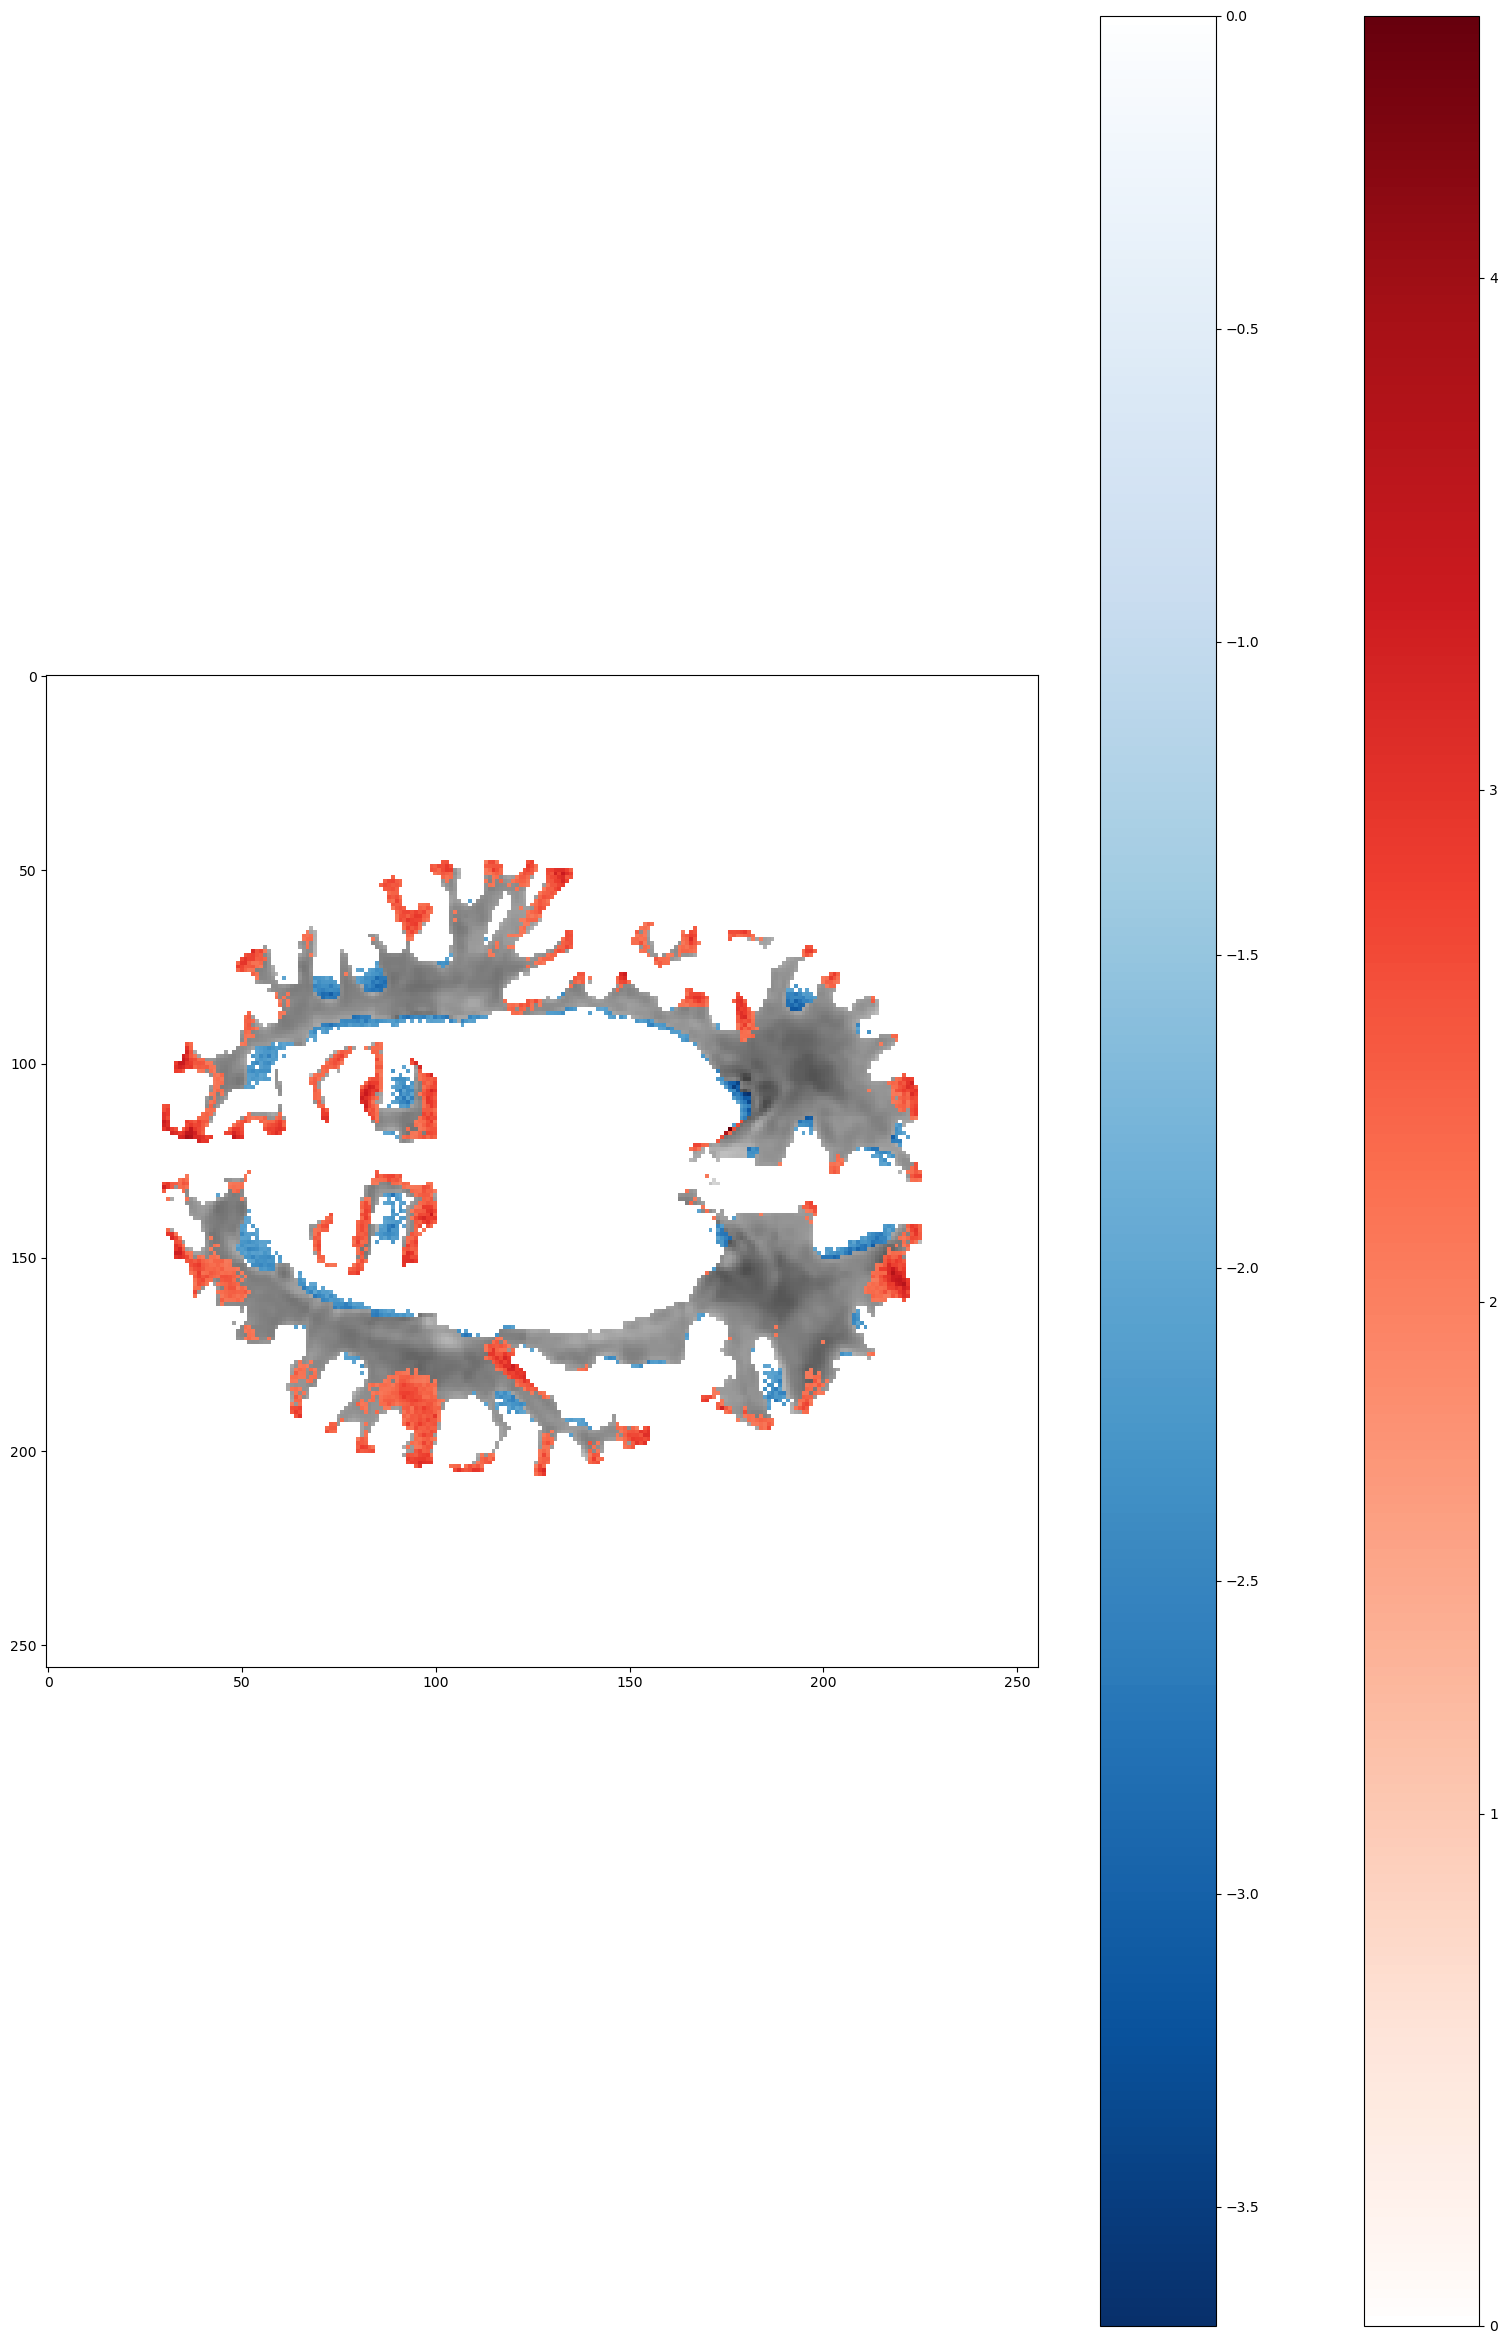

In [141]:
brain_diff(og, output, threshold=2)

# Model Tests All Slices

In [153]:
train = DataRes2Seg(train_out, 2)
val = DataRes2Seg(val_out, 2)
test = DataRes2Seg(test_out, 2)

batch_size=128
train_loader = DataLoader(train, batch_size=batch_size)
val_loader = DataLoader(val, batch_size=batch_size)

In [154]:
len(train)

42496

### Train MinierUNet on Cortical Grey Matter

In [155]:
### This initializes a minier unet with the ground truth in and out
model = MinierUNet(1)

model.cuda()
criterion = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=1e-07)

num_epochs = 100
for epoch in range(num_epochs):
    total_loss = 0
    with tqdm(train_loader, unit="batch", ascii=' >=') as tepoch:
        model.train()
        data_counter = 0
        for data in tepoch:
            optimizer.zero_grad()
            
            og = data["og"].cuda()
            residual = data["res"].cuda()

            output = model(residual)
            loss = criterion(og, output)

            # backward
            loss.backward()
            optimizer.step()

            total_loss += loss.data
            data_counter += 1

        total_loss /= (data_counter)
        
        tepoch.set_postfix(loss=loss.item())
        val_loss = 0
        model.eval()
        data_counter = 0
        for data in val_loader:
            with torch.no_grad():
                og = data["og"].cuda()
                residual = data["res"].cuda()

                output = model(residual)
                loss = criterion(og, output)

                val_loss += loss.data
                data_counter += 1
        
        val_loss /= data_counter
        
        
        print('epoch [{}/{}], train_loss:{:.4f}, val_loss:{:.4f}'
              .format(epoch+1, num_epochs, total_loss, val_loss))

100%|=============================================================================| 332/332 [10:36<00:00,  1.92s/batch]


epoch [1/100], train_loss:0.0030, val_loss:0.0256


 64%|=================================================                            | 212/332 [07:08<04:02,  2.02s/batch]


KeyboardInterrupt: 